# Load libraries. Set precision and fonts

In [2]:
# reload
#%reset
%load_ext autoreload
%autoreload 2 

import warnings
import logging
import os

# DEBUG MODE
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')
logging.getLogger('tensorflow').setLevel(logging.FATAL)
#tf.get_logger().setLevel('ERROR')
    

from helper_functions import *
from tabular_dae.model import DAE
from tabular_dae.model import load as dae_load
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
from torch.optim import Adam
from scarf.loss import NTXent
from scarf.model import SCARF


#from VIME.supervised_models import logit, xgb_model, mlp
from VIME.vime_self import vime_self
#from VIME.vime_semi import vime_semi
from VIME.vime_semi_mod import vime_semi as vime_semi_mod
from VIME.vime_utils import perf_metric
plt.rcParams.update({'font.size': 22})

# Sets the random seed
initialize()
M = (10**6)
K = (10**3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Run with random seed:  163
GPU is available.
1


# Set Experiment Parameters

In [2]:
#========================================
# Experiment Parameters: Check carefully!
#========================================

# This is where models are saved and loaded from
dataset_folder = '../../../dataset_ver1/parsed_data_5steps/'
models_folder = 'models/vime_pretrain/'
pretrain_slice = 'all' #['macro', 'micro', 'slow', 'fast', 'all']
train_slice = 'all' #['macro', 'micro', 'slow', 'fast', 'all', 'only_delay']
test_slice = 'all' #['macro', 'micro', 'slow', 'fast', 'all']
EXP_PARAM = {
    'scaler': 'standard', #'minmax', 'standard', 'robust', 'maxabs', 'l2norm'
    'label_no': 1000000, # number of samples with labels
    'num_rand_runs': 3, # number of runs with each run doing a different random sample of size label_no from the set of labeled samples 
    'error_metric':{'reg':['mae', 'mape'],
                    'clas':['accuracy', 'f1score']},
}

num_samples_list = [100, 1*K, 10*K, 20*K] 

scaler_to_save_name = EXP_PARAM['scaler']+'_scaler'

#==================================
# Pretraining Experiment Parameters
#==================================

pretrain = False
pretrain_type = 'vime' #['dae', 'tabnet']
pretrain_model_to_save_name = pretrain_slice+'_vime_ssl_defhyp'

#==========================================
# Supervised Training Experiment Parameters
#==========================================

# Load an existing sup model to evaluate 
load_sup_model = False
sup_model_to_load_type = 'tabnet'
sup_model_to_load_name = train_slice+'_vime_suptrain_no_pretrain'

# Load an existing pretrained model to use as encoding for sup model 
use_pretrained_model = False
pretrain_model_to_load_type = 'vime' #['dae', 'tabnet']
pretrain_model_to_load_name = pretrain_slice+'_vime_ssl_defhyp.h5' #'vime_encoder_model.h5'
scaler_to_load_name = 'minmax_scaler.pkl'

# Train a sup model with or without using a pretrained model 
sup_model_type = 'xgb' #['mlp', 'xgb', 'tabnet', 'vime']
suptrain_model_to_save_name = train_slice+'_xgb' # could also be sup_model_with_pretrain 


#==================================================
# Experiment Parameters: Not often changed
#==================================================

time_step_size = '500ms'

# When input features are NA 
# Could experiment with forward fill imputation 
# If the label is NA during supervised training then the sample is dropped  
impute_method = 'forward_fill'# ['forward_fill', 'zero_fill']
                              
# These are the ones we have chosen to work with  
#learning_tasks = ['httpClientRtt_trace.txt_page_load_time']
learning_tasks = ['dashClient_trace.txt_newBitRate_bps', 
                  'vrFragment_trace.txt_vr_frag_thput_mbps', 'vrFragment_trace.txt_vr_burst_thput_mbps',
                  'vrFragment_trace.txt_vr_frag_time', 'vrFragment_trace.txt_vr_burst_time', 
                  'httpClientRtt_trace.txt_page_load_time',
                  'delay_trace.txt_ul_delay', 'delay_trace.txt_dl_delay']
# index matched with the learning_tasks above
#learning_task_types = ['reg']
learning_task_types = ['clas', 
                       'reg', 'reg', 
                       'reg', 'reg',
                       'reg',
                       'reg', 'reg']

# If True then we are predicting one window ahead if False then we are predicting on the same window 
shift_samp_for_predict = False

# If you want the test samples to be sorted by delay value to see the error differences for the low delay and high delay cases 
sort_test_samples = False

use_all_feats = True
# take the top n features of each run and add it to the top_n_features list  
# If use_all_feats = True then thes will not be used 
feat_filter = 10 
top_n_features = []
# Only valid when use_all_feats = False 
selected_features = []

# All delay values above this will be clipped to the threshold value
clip_outliers = True
delay_clip_th = 5000 # ms

# Set Model Hyperparameters

In [3]:
if sup_model_type == 'tabnet':
    sup_hyper_params=hypp_sup_tabnet
elif sup_model_type == 'mlp':
    sup_hyper_params=hypp_sup_mlp
elif sup_model_type == 'xgb':
    sup_hyper_params=hypp_sup_xgb    


#pretrain_runs = range(1, 10 + 1)
#train_runs = range(11, 17 + 1)
#test_runs = range(18, 20 + 1)

num_pretrain_runs = 10
num_train_runs = 7
num_test_runs = 3
train_test_run_nums = np.array(range(11, 20+1))

# Create the models_folder if it does not already exist
if not os.path.isdir(models_folder):
    os.makedirs(models_folder)

# Process data frame before separating out learning task

## - Read run from file
## - Separate out data slice
## - Name first column as timestamp
## - Drop unwanted columns mentioned in drop_cols

In [ ]:
pretrain_runs = range(1, 10 + 1)
pretrain_data = read_and_concatenate_runs(pretrain_runs, dataset_folder, pretrain_slice, network_info, 
                                          time_step_size, use_all_feats, drop_col_substr)
# Add a feature with cell_conn_type as a featurte that indicates whether it is macro or micro cell 
pretrain_data = add_cell_type_as_feature(pretrain_data, network_info)

# Pretrain a new model

In [16]:
if pretrain:
    # Separate the X and the ys from the data
    # remove the labels of all prediction tasks which are also in the datset 
    X_pretrain = pretrain_data.drop(all_learning_tasks_in_data, axis=1, errors='ignore')
    print(X_pretrain.shape)
    
    # Fill with 0 the values that are missing in the input features so that the sample can still be used
    print('Imputing NA in samples with method ', impute_method)
    print('Number of rows with NA values in the input features: ', len(X_pretrain[X_pretrain.isna().any(axis=1)]))
    print('Fraction of rows with NA values in the input features: ', len(X_pretrain[X_pretrain.isna().any(axis=1)])/X_pretrain.shape[0])
    X_pretrain = impute_data(X_pretrain, impute_method, sum_cols_substr)
    
    val_scaler = create_scaler(X_pretrain, EXP_PARAM['scaler'])
    # Save the scaler for later use when doing supervised training 
    with open(models_folder + scaler_to_save_name +'.pkl', 'wb') as f:
        pickle.dump(val_scaler, f)

    # Use the scaler to scale
    X_pretrain = val_scaler.transform(X_pretrain).copy()
    
    if pretrain_type == 'dae':
        pretrain_model = pretrain_with_dae(pd.DataFrame(X_pretrain))
        # save this pretrained model for later use 
        pretrain_model.save(models_folder+pretrain_model_to_save_name)
    elif pretrain_type == 'tabnet':
        X_pretrain, X_pretrain_val = train_test_split(X_pretrain, test_size=0.2, shuffle=True) 
        pretrain_model = pretrain_with_tabnet(pd.DataFrame(X_pretrain),  pd.DataFrame(X_pretrain_val))
        pretrain_model.save_model(models_folder+pretrain_model_to_save_name)
        # show the results of feature importance
        tabnet_explain(pretrain_model, X_pretrain_val)
    elif pretrain_type == 'vime':
        # Train VIME-Self
        vime_self_parameters = dict()
        vime_self_parameters['batch_size'] = hyp_ssl_semi_vime['batch_size']
        vime_self_parameters['epochs'] = hyp_ssl_semi_vime['epochs'] 
        vime_self_encoder = vime_self(X_pretrain, hyp_ssl_semi_vime['p_m'], hyp_ssl_semi_vime['alpha'], vime_self_parameters)  
        # Save encoder
        vime_self_encoder.save(models_folder+pretrain_model_to_save_name+'.h5')

# Load Tabnet pretrained model for explainability results

In [22]:
# Load a pretrained model for getting explainability results
# Load the pretrained model and scaler 
#with open(models_folder + scaler_to_load_name + '.pkl', 'rb') as f:
#    val_scaler = pickle.load(f)
#
#
## remove the labels of all prediction tasks which are also in the datset 
#X_pretrain_val = test_data.drop(all_learning_tasks_in_data, axis=1, errors='ignore')
#print(X_pretrain_val.shape)
#
## Fill with 0 the values that are missing in the input features so that the sample can still be used
#X_pretrain_val = impute_data(X_pretrain_val, impute_method, sum_cols_substr)
#
#X_pretrain_val = val_scaler.transform(X_pretrain_val).copy()
# 
#if pretrain_model_to_load_type == 'tabnet':
#    pretrain_model = TabNetPretrainer()
#    pretrain_model.load_model(models_folder+pretrain_model_to_load_name)
#    X_pretrain_val = pretrain_model.predict(X_pretrain_val)[0]
#    tabnet_explain(pretrain_model, X_pretrain_val)
#else:
#    print('Do not have explainability functionality for this model type')

# Train and test model 
## Iterate over learning_tasks

Num. labeled samples:  100
# train runs used  7
# test runs used  3
Concatenating runs:  [11 17 16 13 14 18 20]
Loaded run 11
Loaded run 17
Loaded run 16
Loaded run 13
Loaded run 14
Loaded run 18
Loaded run 20
(1259370, 470)
Concatenating runs:  [12 19 15]
Loaded run 12
Loaded run 19
Loaded run 15
(539730, 470)
Learning task:  dashClient_trace.txt_newBitRate_bps
clas
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(44651, 470)
(18773, 470)
(array([  45000,   89000,  131000,  178000,  221000,  263000,  334000,
        396000,  522000,  595000,  791000, 1033000, 1245000, 1547000,
       2134000, 2484000, 3079000, 3527000, 3840000]), array([   77,    37,    45,    44,    63,    73,    87,   172,   120,
         360,   527,   487,   643,  1629,   969,  1891,  1465,   743,
       35219]))
(array([0, 1, 2]), array([ 2735,  4489, 37427]))
(array([  45000,   89000,  131000,  178000,  221000,  263000,  334000,
        396000,  5

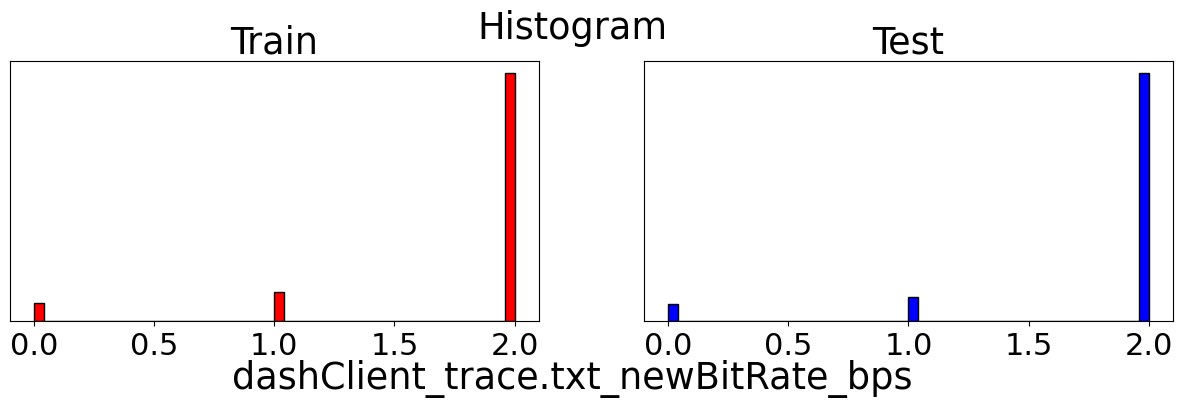

Time to train model:  0.7119956016540527


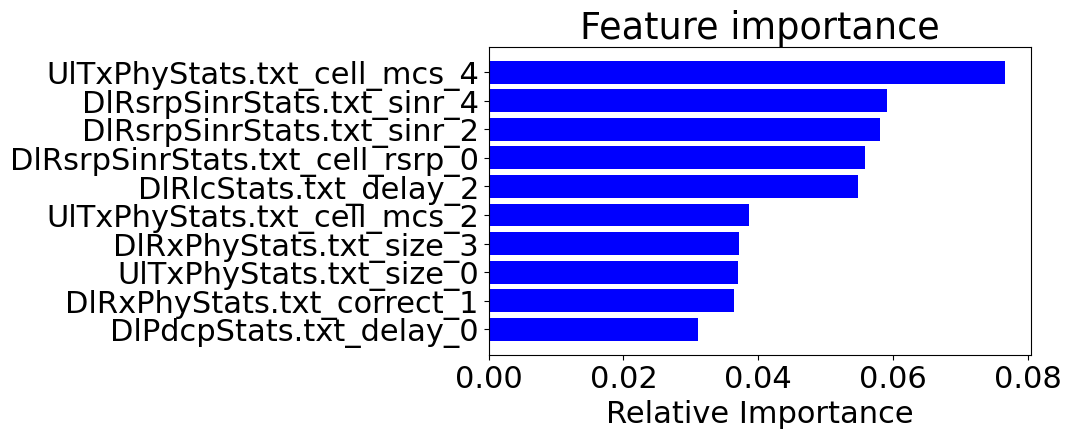

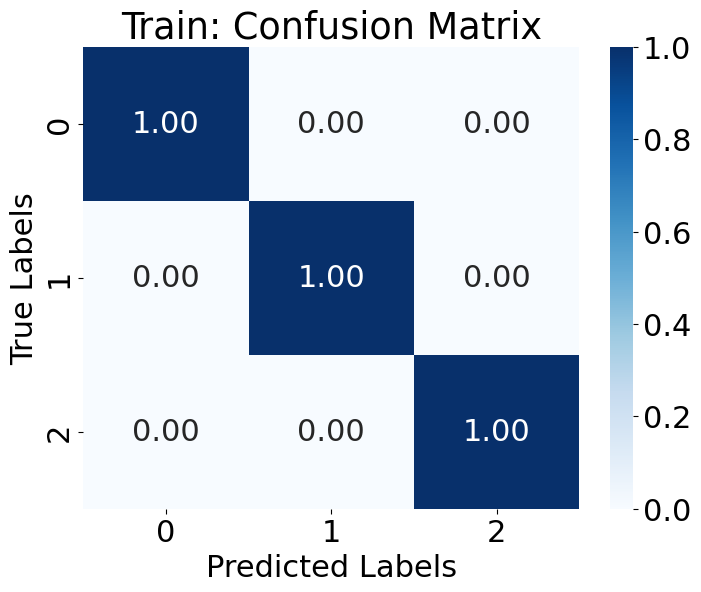

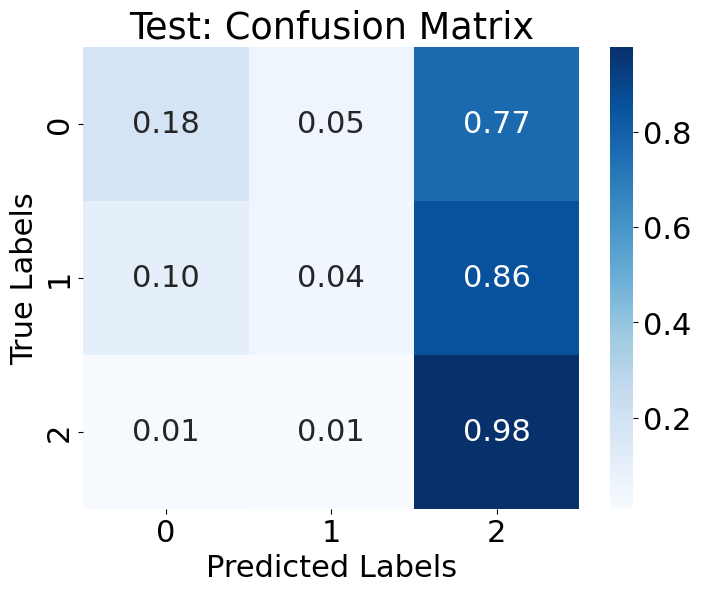



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_frag_thput_mbps
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(23092, 470)
(9894, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  175
After Imputing: Number of cols with NaNs in the data:  0
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [16443  1778  1645  2065   930]
After removing bins that are not populated enough
[0 1 2 3 4] [16443  1778  1645  2065   930]
(22861, 460)
(22861,)
(22861,)
bin_and_remove_outliers
Before removing bins

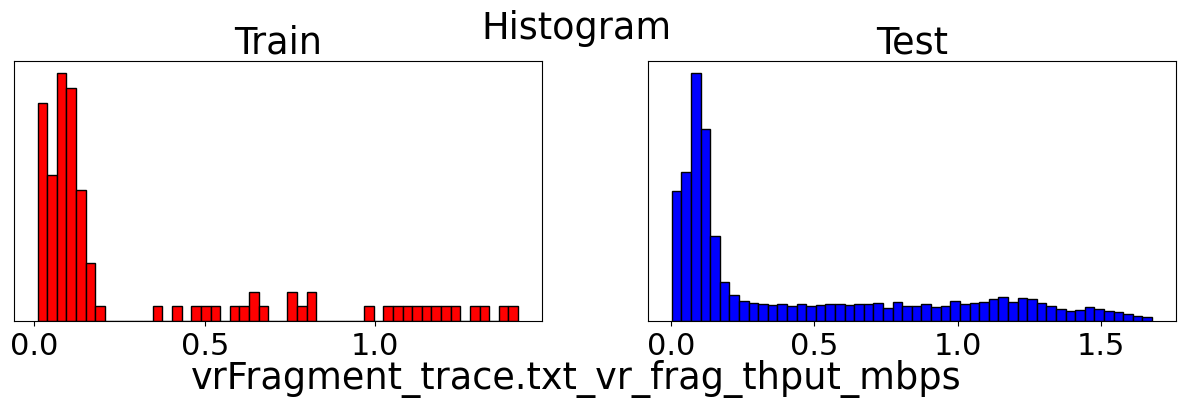

Time to train model:  0.41402292251586914


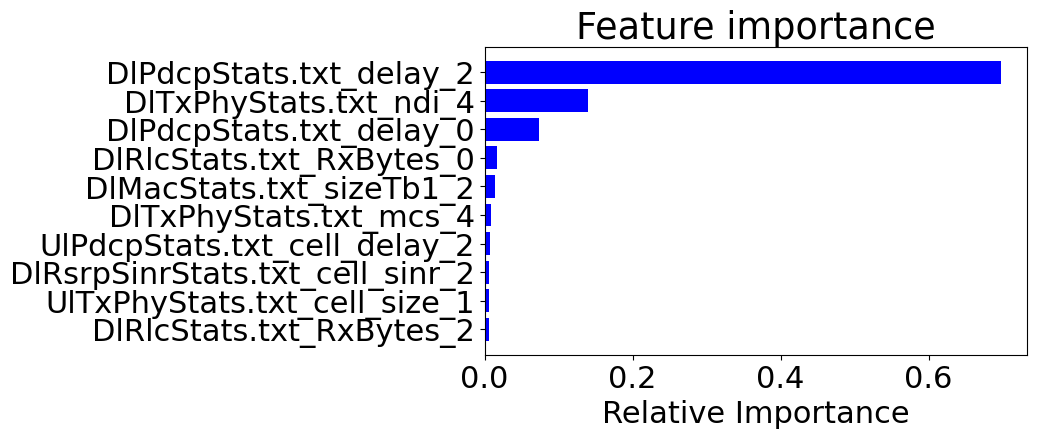

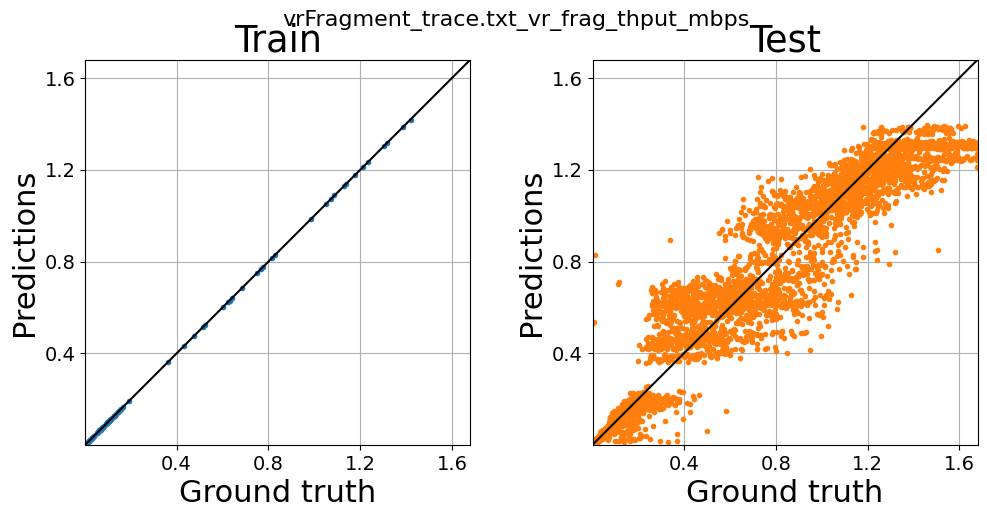



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_thput_mbps
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(23064, 470)
(9887, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  169
After Imputing: Number of cols with NaNs in the data:  0
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [16558  1782  1711  1848   934]
After removing bins that are not populated enough
[0 1 2 3 4] [16558  1782  1711  1848   934]
(22833, 460)
(22833,)
(22833,)
bin_and_remove_outliers
Before removing bin

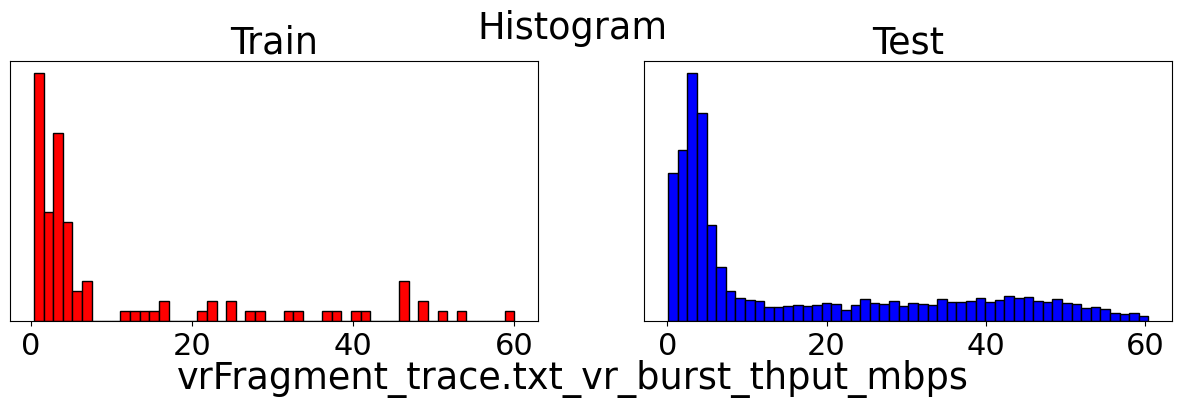

Time to train model:  0.6273746490478516


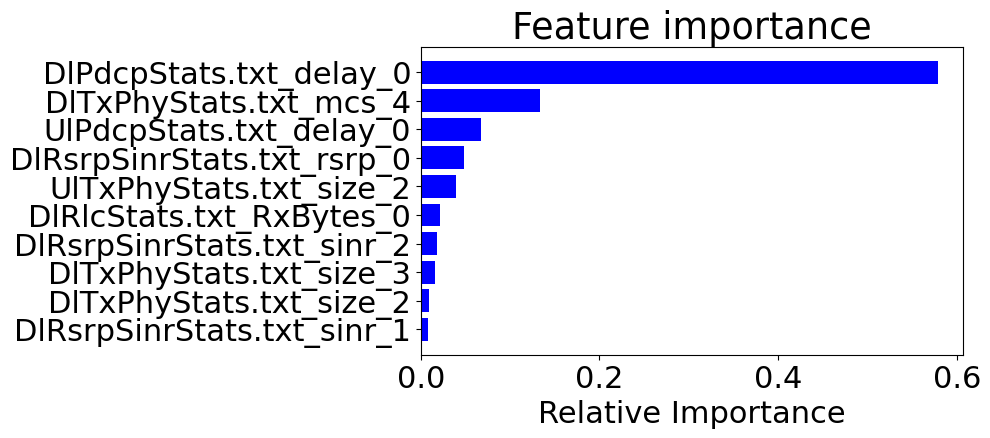

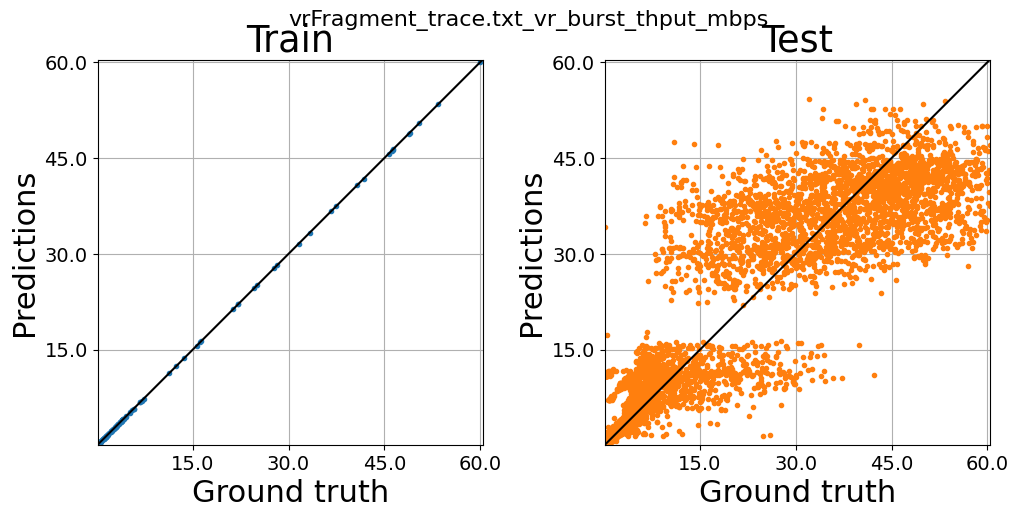



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_frag_time
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(23092, 470)
(9894, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  175
After Imputing: Number of cols with NaNs in the data:  0
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [17848  3090  1144   521   258]
After removing bins that are not populated enough
[0 1 2 3 4] [17848  3090  1144   521   258]
(22861, 460)
(22861,)
(22861,)
bin_and_remove_outliers
Before removing bins that 

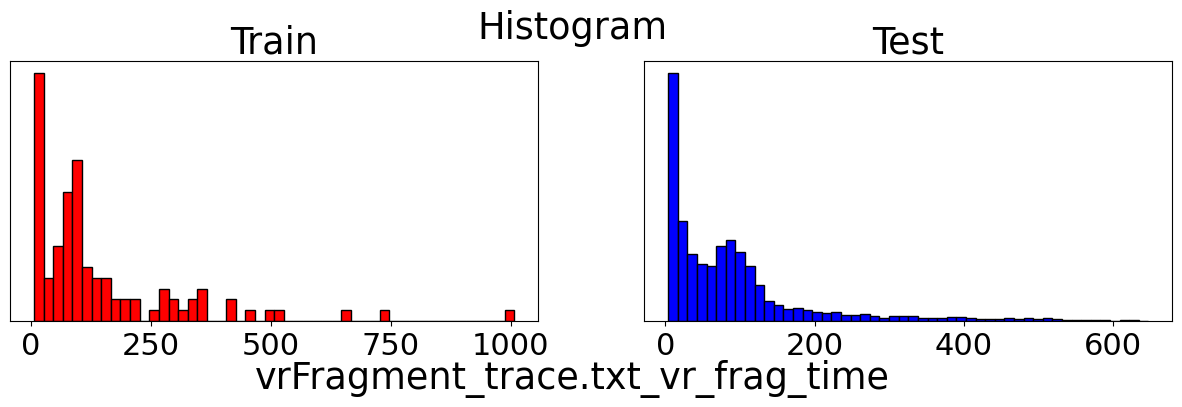

Time to train model:  0.7088441848754883


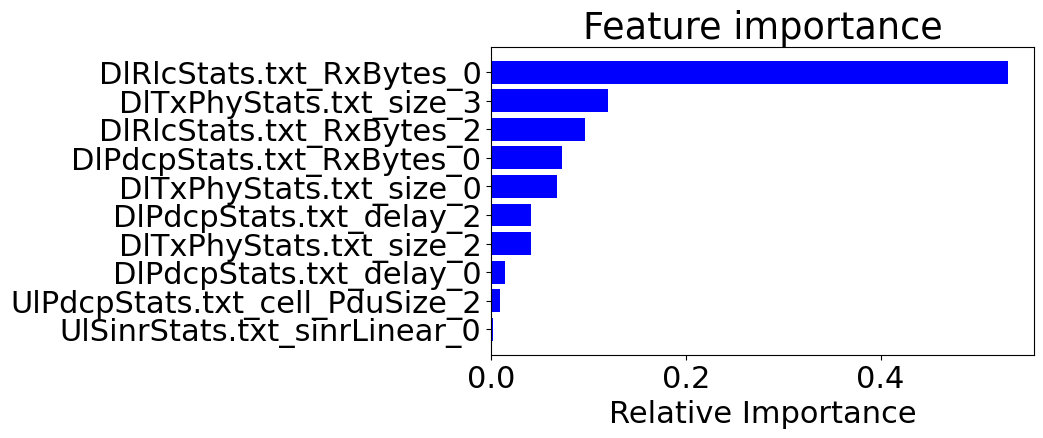

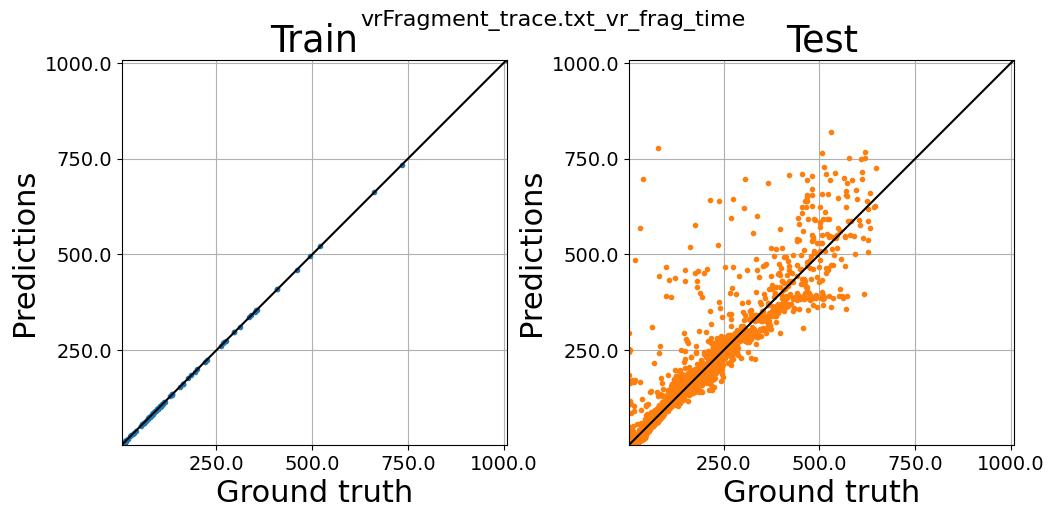



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_time
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(23064, 470)
(9887, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  169
After Imputing: Number of cols with NaNs in the data:  0
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [17789  3087  1171   525   261]
After removing bins that are not populated enough
[0 1 2 3 4] [17789  3087  1171   525   261]
(22833, 460)
(22833,)
(22833,)
bin_and_remove_outliers
Before removing bins that

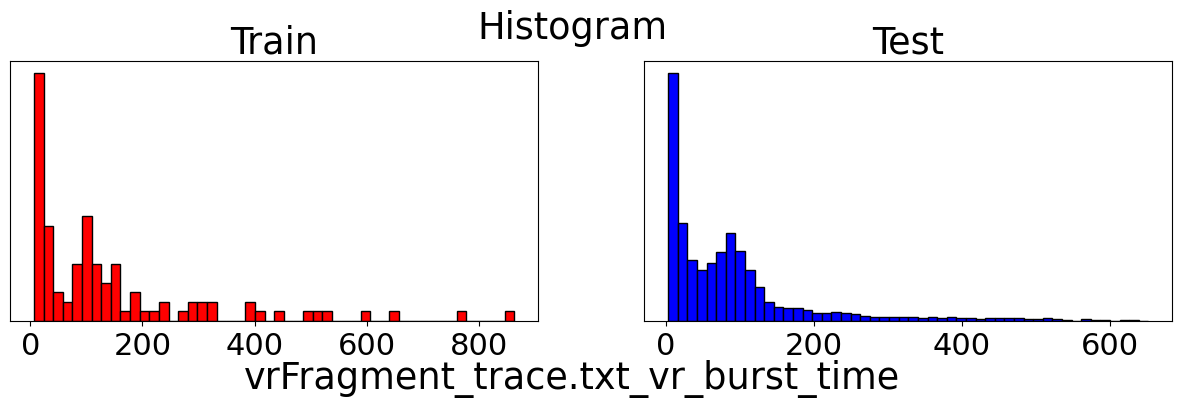

Time to train model:  0.7345151901245117


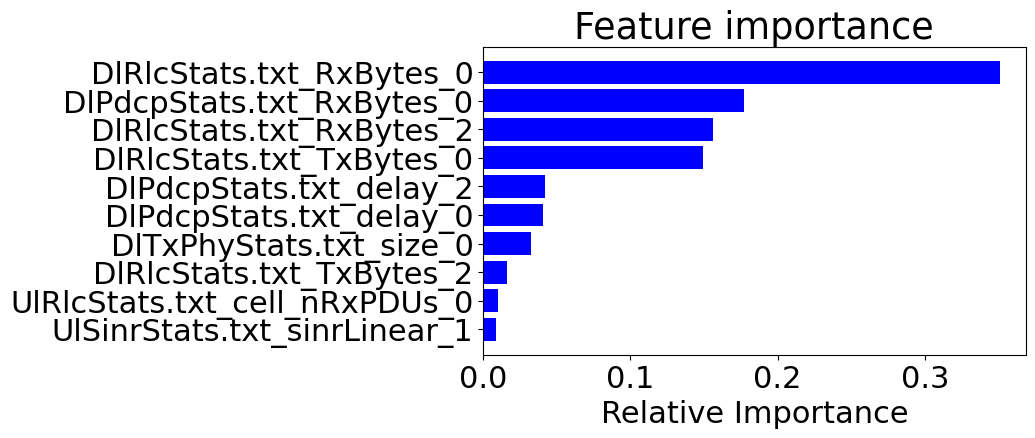

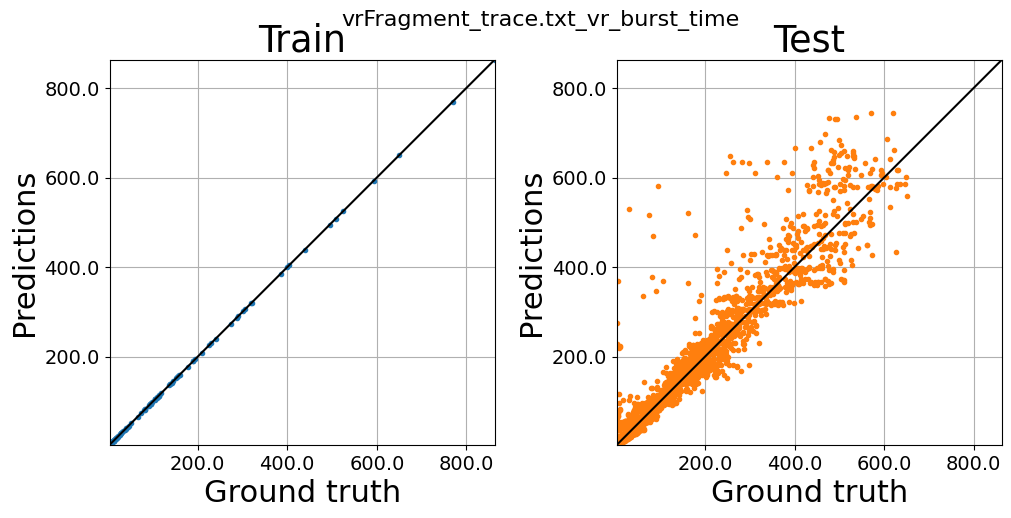



===============================  DONE  ===================================================
Learning task:  httpClientRtt_trace.txt_page_load_time
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(3173, 470)
(1351, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  159
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  151
After Imputing: Number of cols with NaNs in the data:  0
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [3066   20   18   18   19]
After removing bins that are not populated enough
[0 1 2 3 4] [3066   20   18   18   19]
(3066, 460)
(3066,)
(3066,)
bin_and_remove_outliers
Before removing bins that are not p

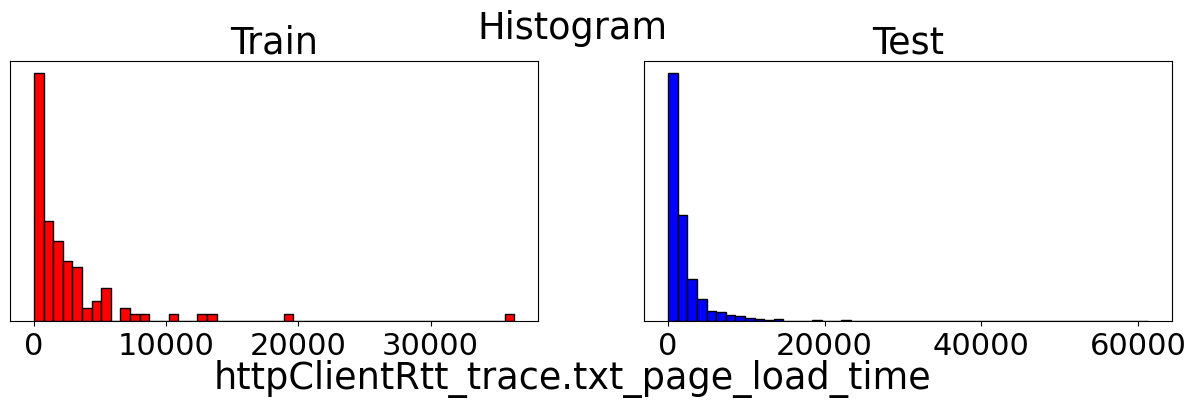

Time to train model:  0.9236042499542236


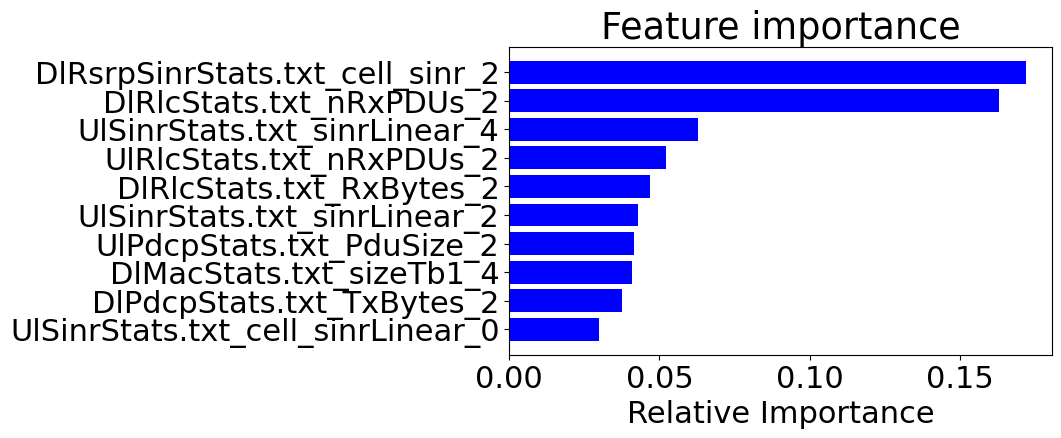

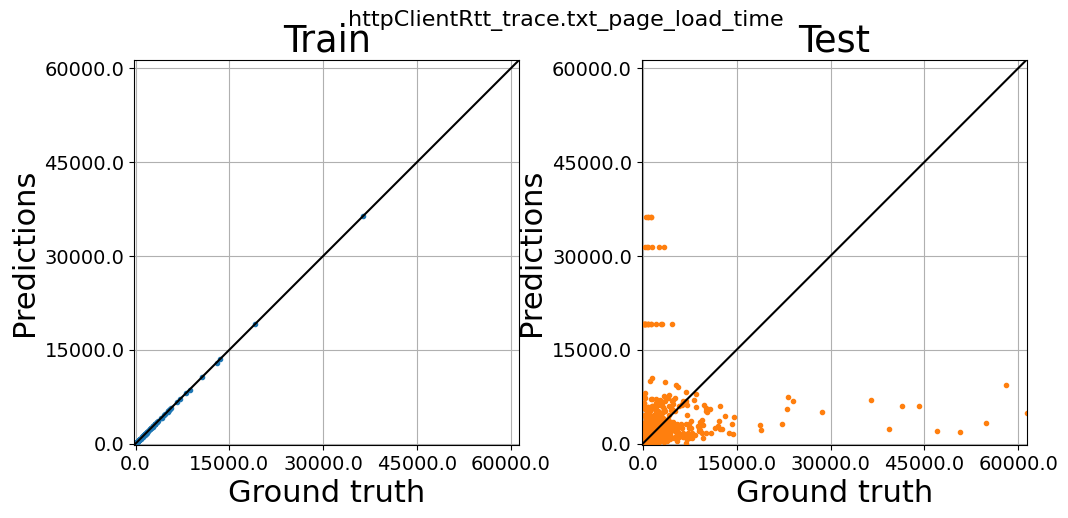



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_ul_delay
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(1188994, 470)
(507570, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  308
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  305
After Imputing: Number of cols with NaNs in the data:  0
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [1166802    4842    2459    1705    1296]
After removing bins that are not populated enough
[0 1 2 3 4] [1166802    4842    2459    1705    1296]
(1166802, 460)
(

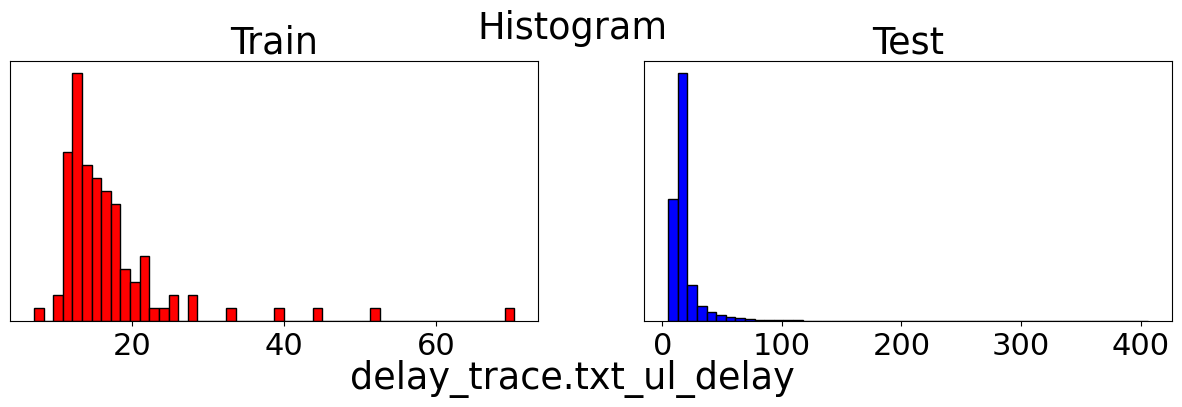

Time to train model:  2.897763252258301


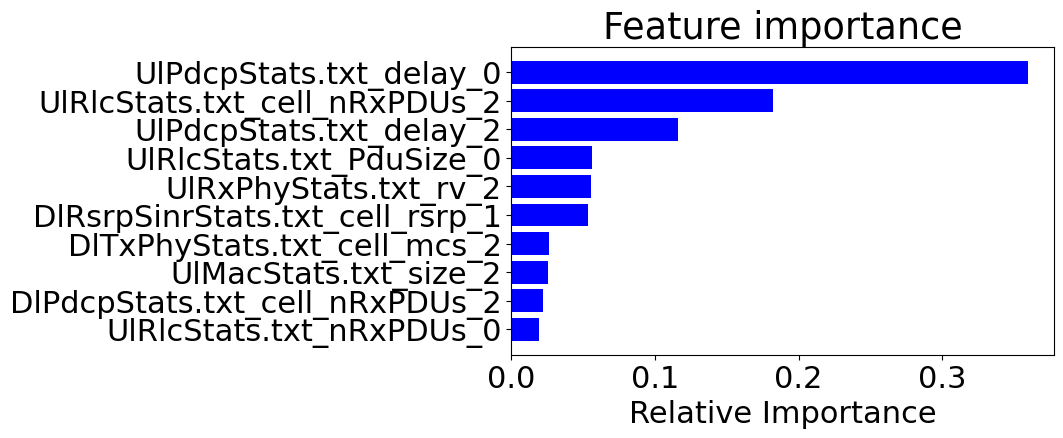

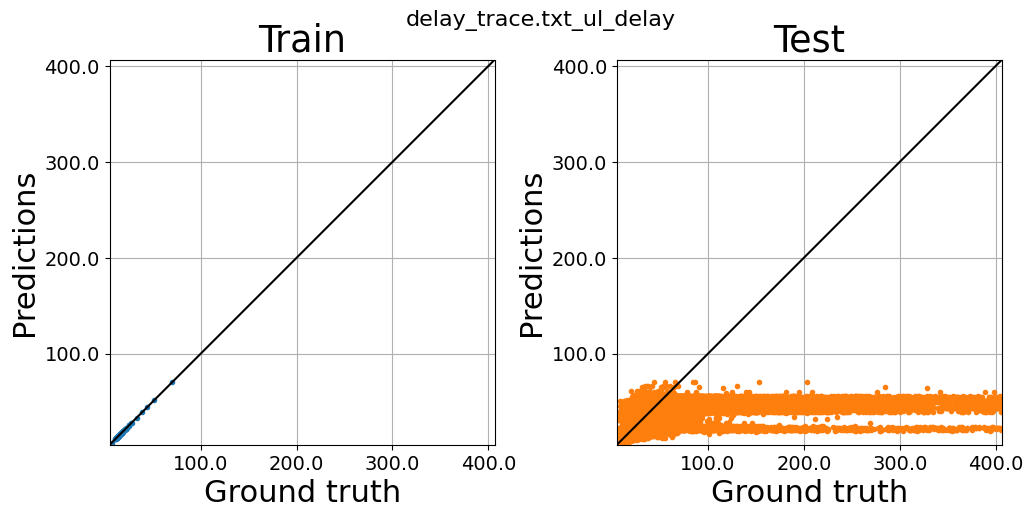



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_dl_delay
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(1258125, 470)
(539308, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  230
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  230
After Imputing: Number of cols with NaNs in the data:  0
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [1155218   51707   21786   10587    6246]
After removing bins that are not populated enough
[0 1 2 3 4] [1155218   51707   21786   10587    6246]
(1228711, 460)
(

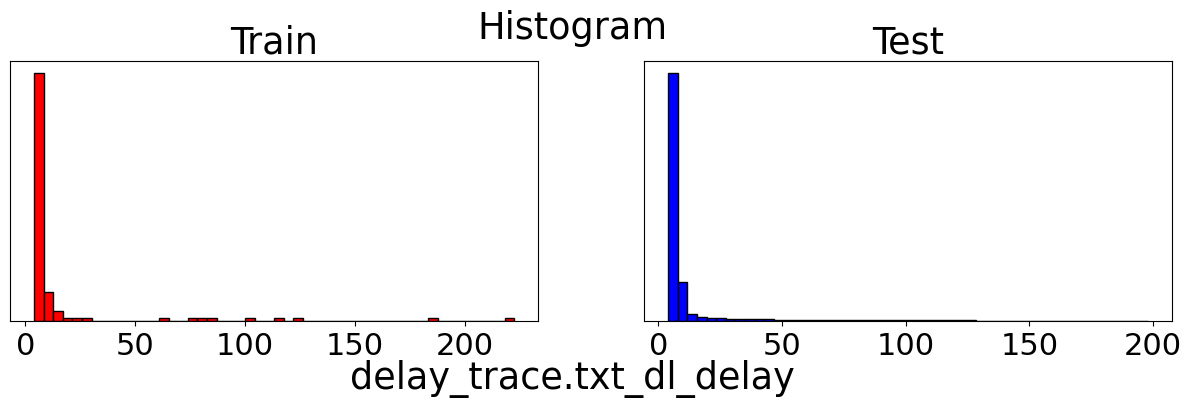

Time to train model:  3.026200771331787


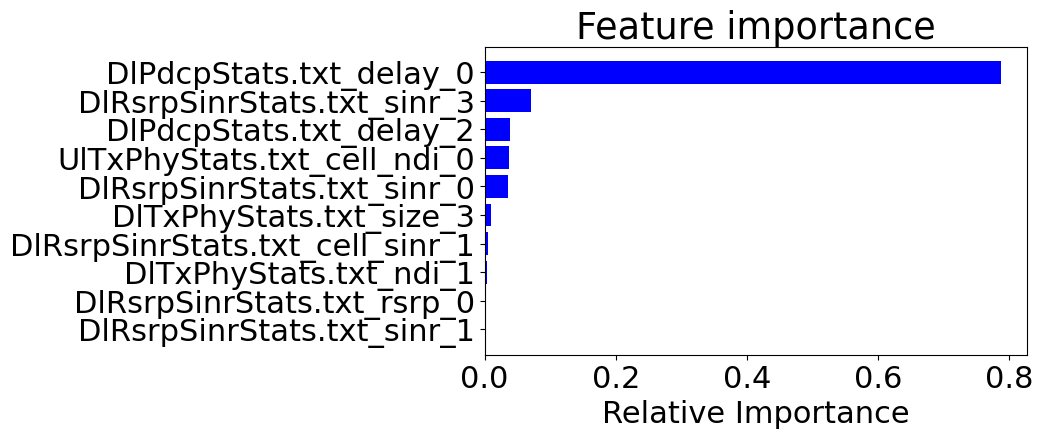

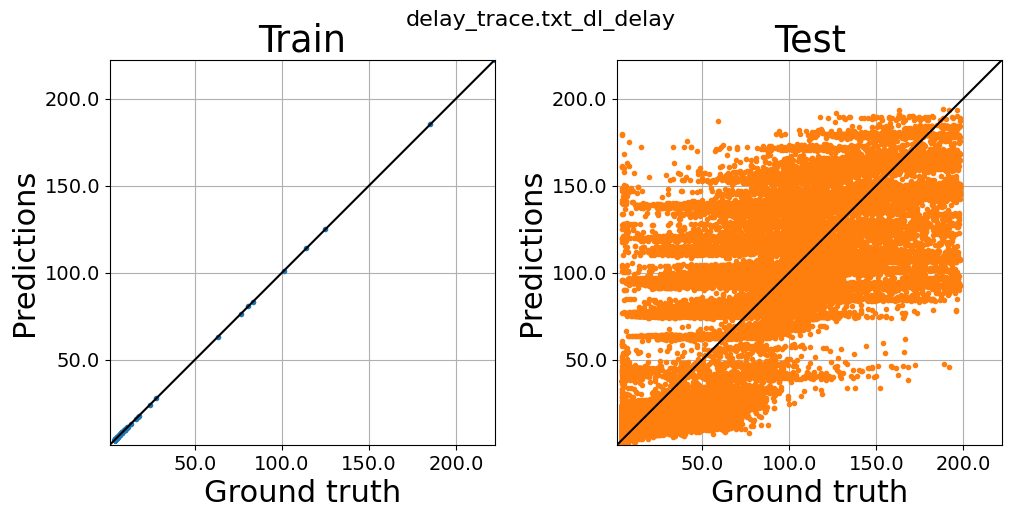



===============================  DONE  ===================================================
# train runs used  7
# test runs used  3
Concatenating runs:  [14 20 16 15 19 17 13]
Loaded run 14
Loaded run 20
Loaded run 16
Loaded run 15
Loaded run 19
Loaded run 17
Loaded run 13
(1259370, 470)
Concatenating runs:  [12 11 18]
Loaded run 12
Loaded run 11
Loaded run 18
(539730, 470)
Learning task:  dashClient_trace.txt_newBitRate_bps
clas
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(44121, 470)
(19303, 470)
(array([  45000,   89000,  131000,  178000,  221000,  263000,  334000,
        396000,  522000,  595000,  791000, 1033000, 1245000, 1547000,
       2134000, 2484000, 3079000, 3527000, 3840000]), array([   75,    35,    49,    57,    58,    78,    91,   179,   118,
         402,   551,   493,   653,  1594,   986,  1807,  1417,   730,
       34748]))
(array([0, 1, 2]), array([ 2839,  4387, 36895]))
(array([  45000,   8900

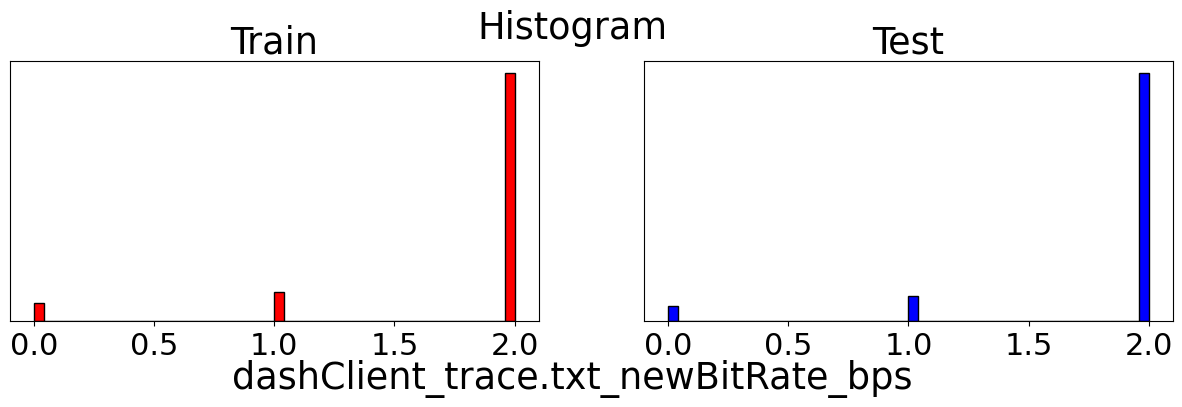

Time to train model:  0.7001028060913086


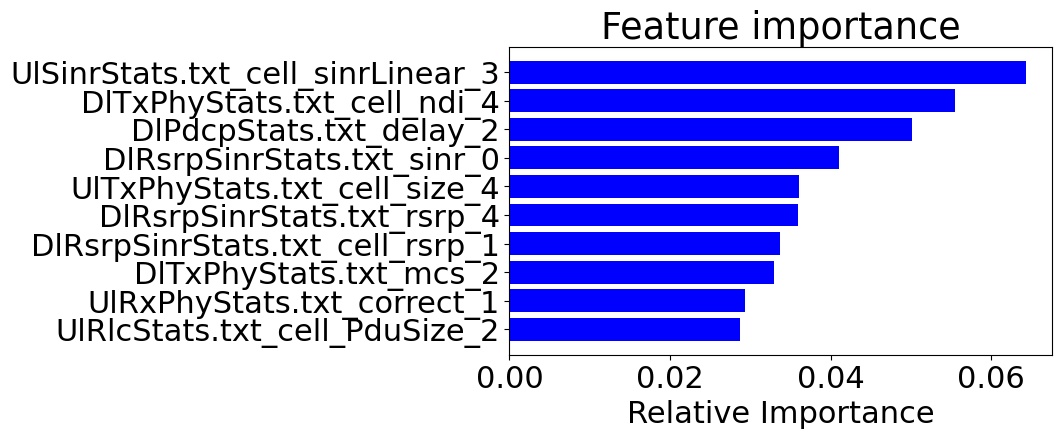

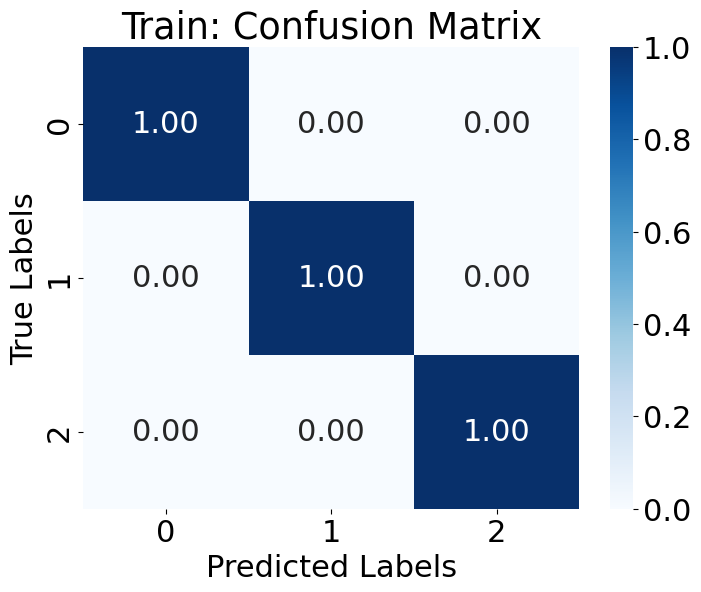

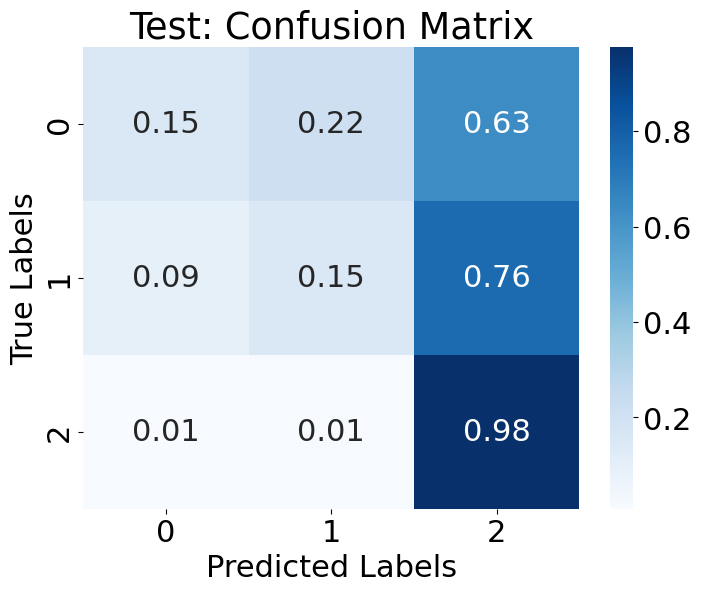



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_frag_thput_mbps
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(23094, 470)
(9892, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  176
After Imputing: Number of cols with NaNs in the data:  0
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [15747  1833  1809  2391  1083]
After removing bins that are not populated enough
[0 1 2 3 4] [15747  1833  1809  2391  1083]
(22863, 460)
(22863,)
(22863,)
bin_and_remove_outliers
Before removing bins

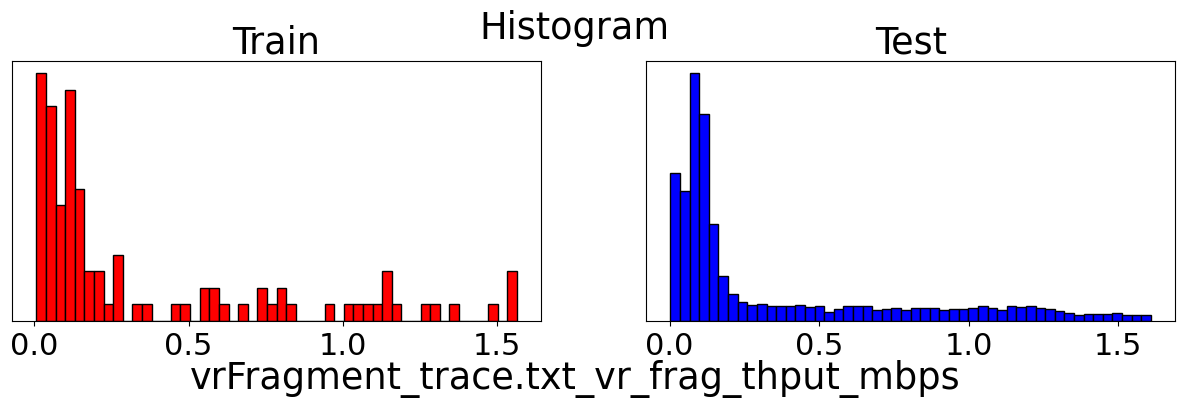

Time to train model:  0.3987140655517578


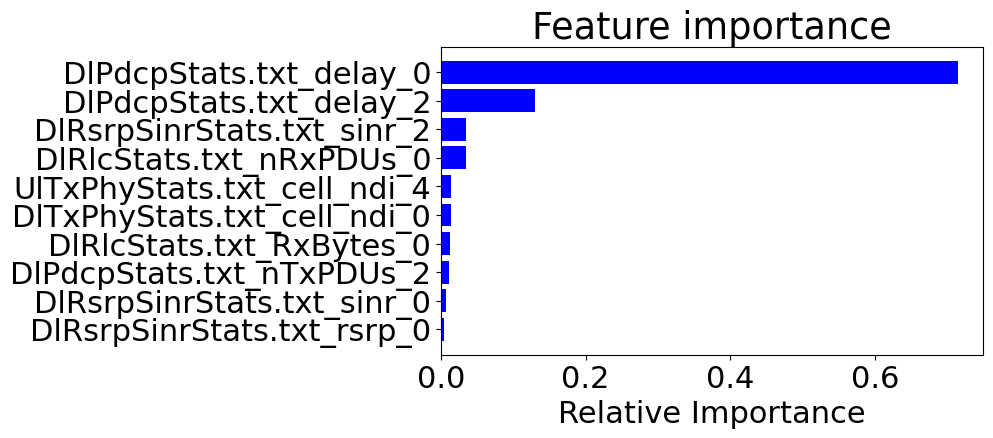

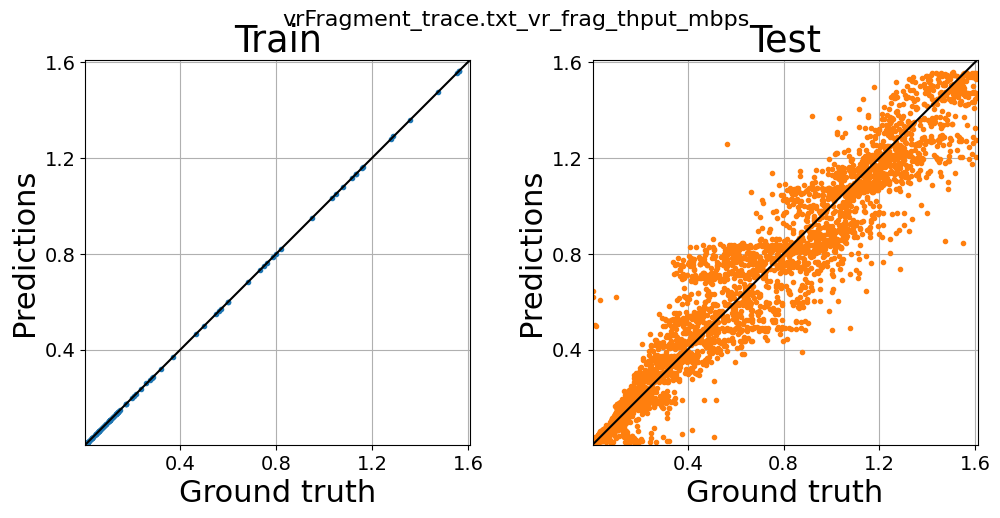



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_thput_mbps
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(23066, 470)
(9885, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  176
After Imputing: Number of cols with NaNs in the data:  0
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [15875  1780  1928  2179  1073]
After removing bins that are not populated enough
[0 1 2 3 4] [15875  1780  1928  2179  1073]
(22835, 460)
(22835,)
(22835,)
bin_and_remove_outliers
Before removing bin

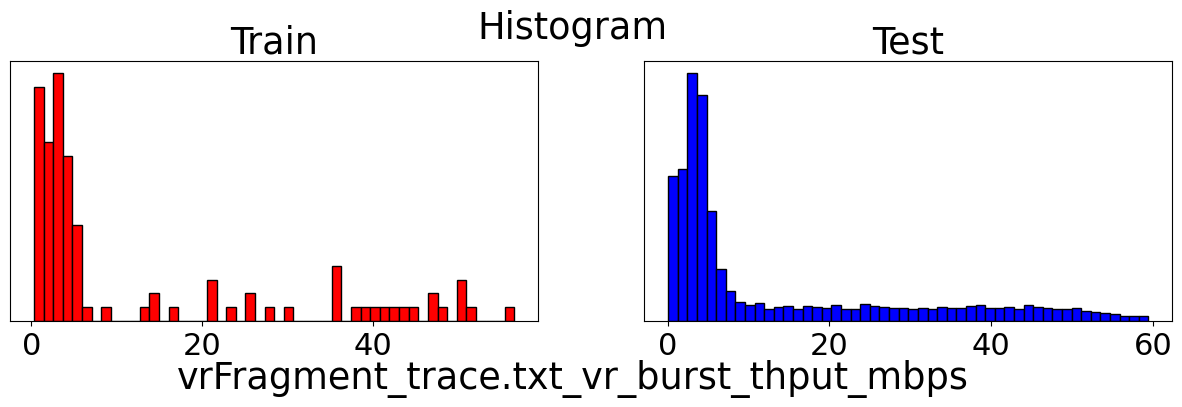

Time to train model:  0.5711421966552734


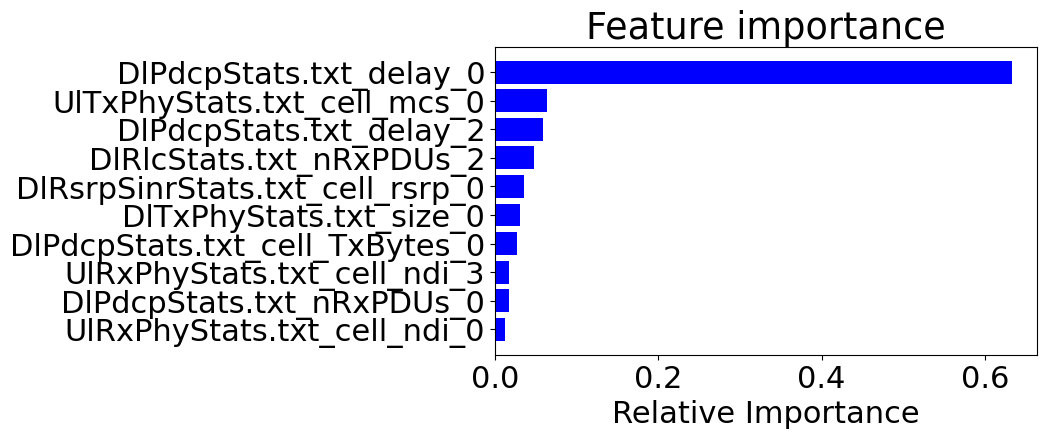

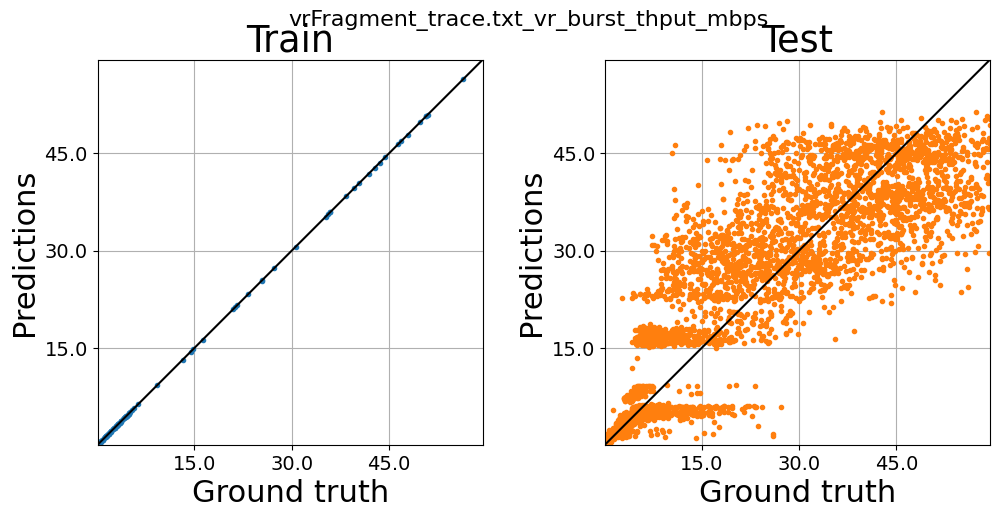



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_frag_time
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(23094, 470)
(9892, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  176
After Imputing: Number of cols with NaNs in the data:  0
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [18186  2843  1082   508   244]
After removing bins that are not populated enough
[0 1 2 3 4] [18186  2843  1082   508   244]
(22863, 460)
(22863,)
(22863,)
bin_and_remove_outliers
Before removing bins that 

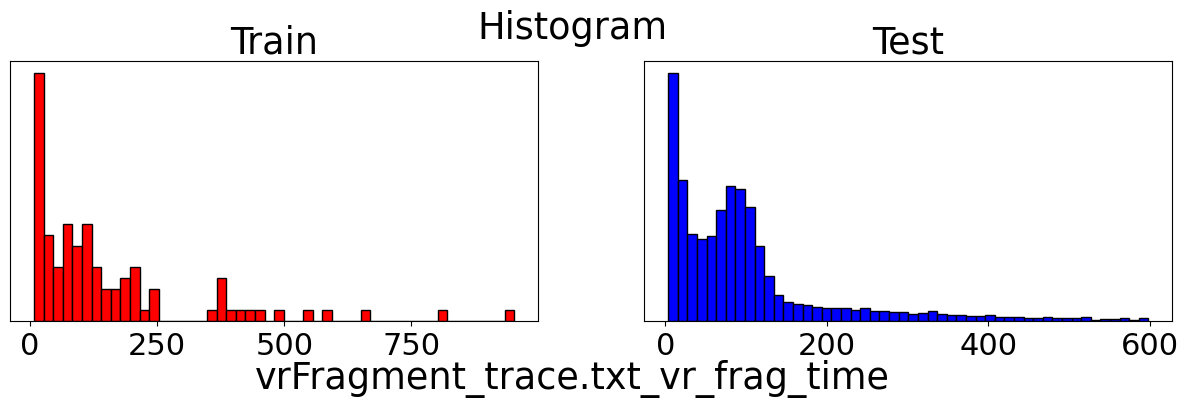

Time to train model:  0.6709301471710205


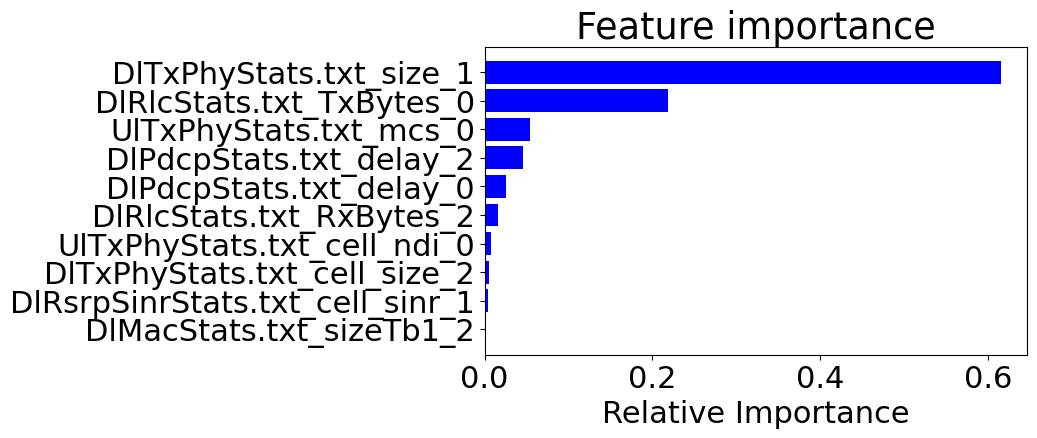

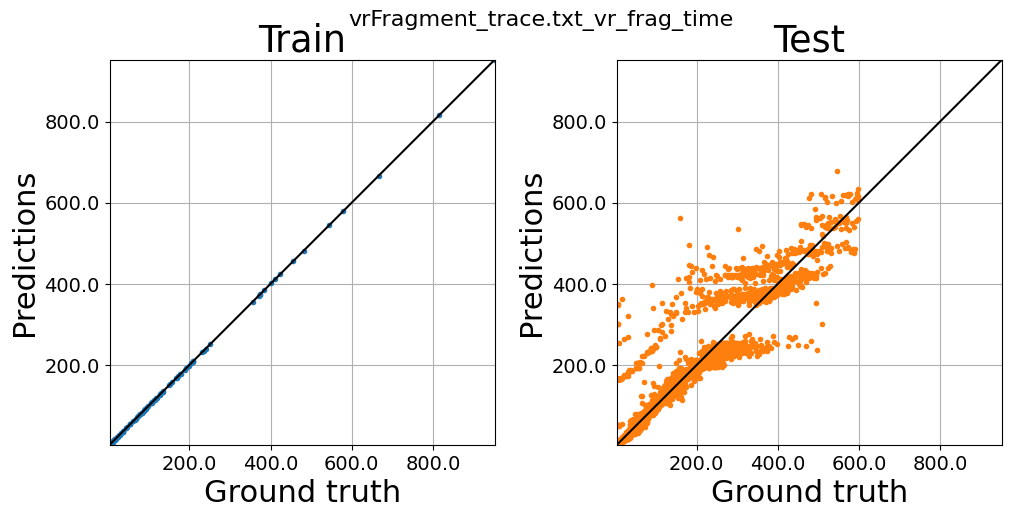



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_time
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(23066, 470)
(9885, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  176
After Imputing: Number of cols with NaNs in the data:  0
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [18150  2836  1107   498   244]
After removing bins that are not populated enough
[0 1 2 3 4] [18150  2836  1107   498   244]
(22835, 460)
(22835,)
(22835,)
bin_and_remove_outliers
Before removing bins that

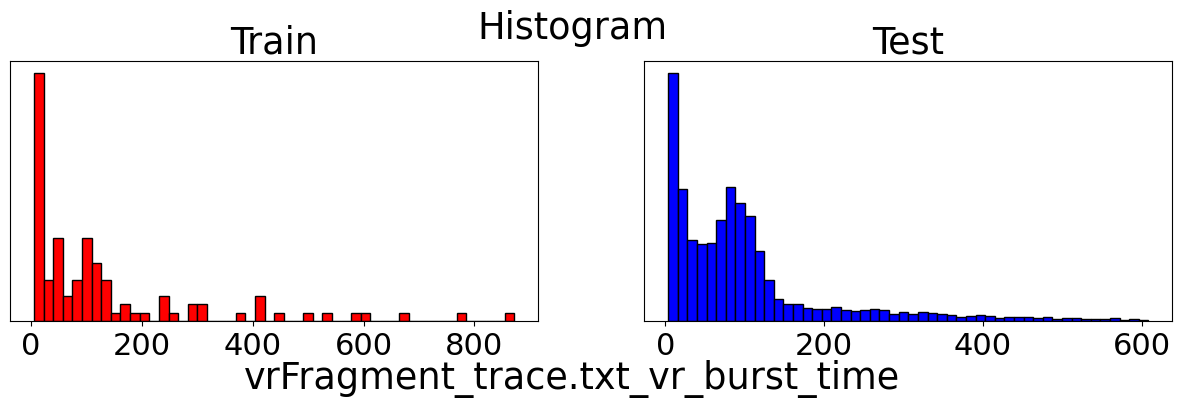

Time to train model:  0.713874101638794


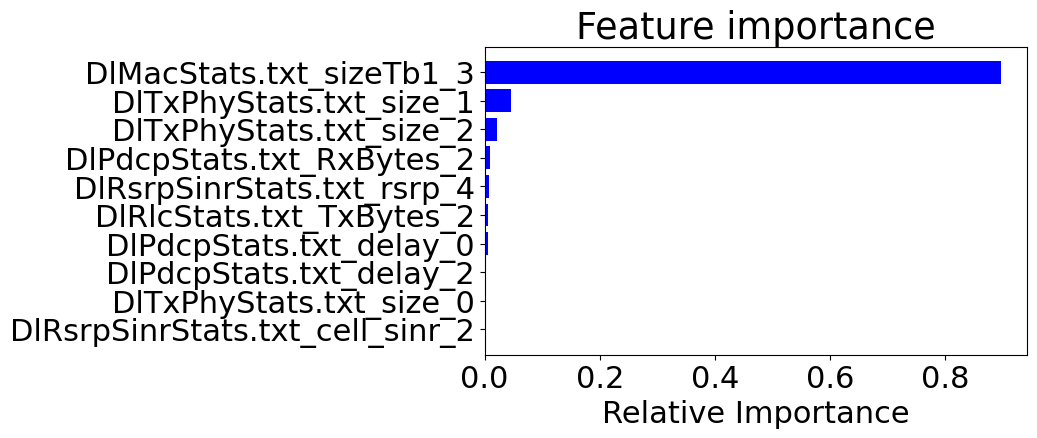

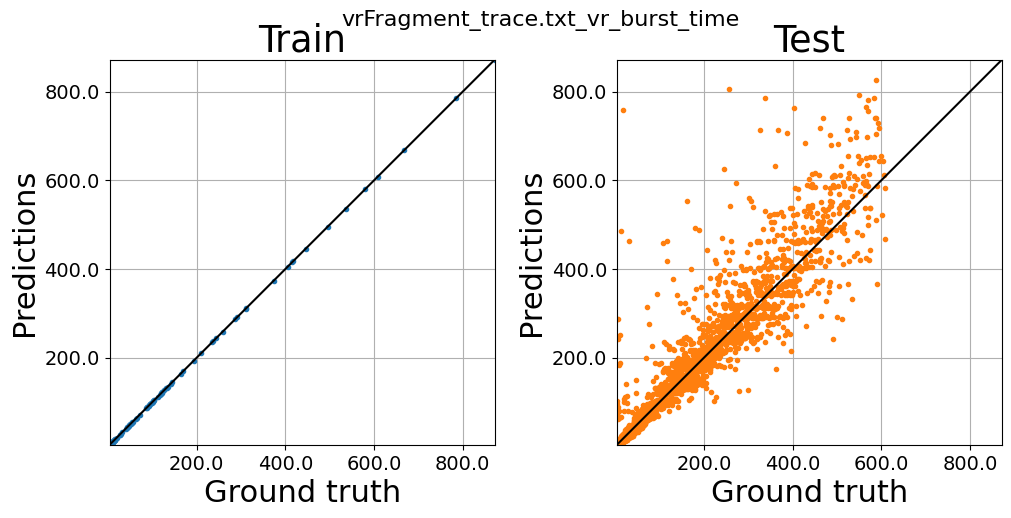



===============================  DONE  ===================================================
Learning task:  httpClientRtt_trace.txt_page_load_time
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(3138, 470)
(1386, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  78
After Imputing: Number of cols with NaNs in the data:  8
Before Imputing: Number of cols with NaNs in the data:  151
After Imputing: Number of cols with NaNs in the data:  0
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [3034   17   21   18   16]
After removing bins that are not populated enough
[0 1 2 3 4] [3034   17   21   18   16]
(3034, 460)
(3034,)
(3034,)
bin_and_remove_outliers
Before removing bins that are not po

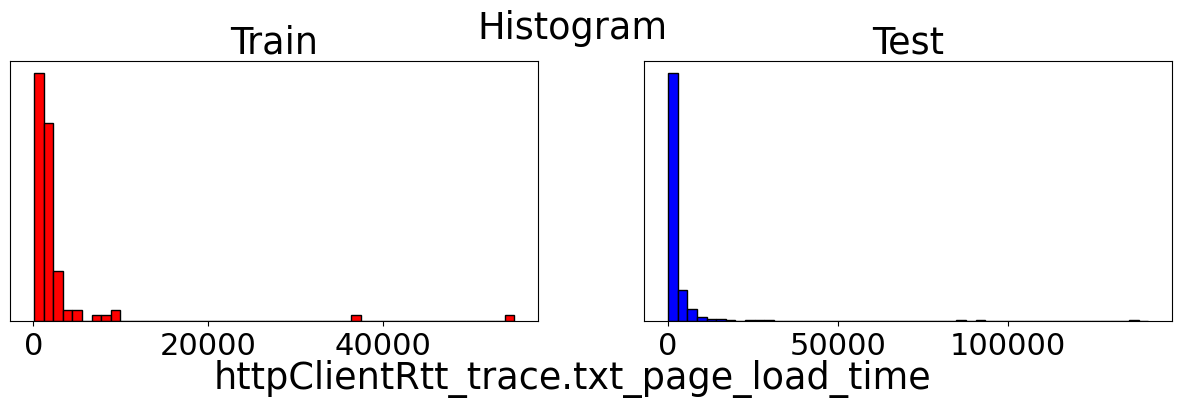

Time to train model:  0.8947577476501465


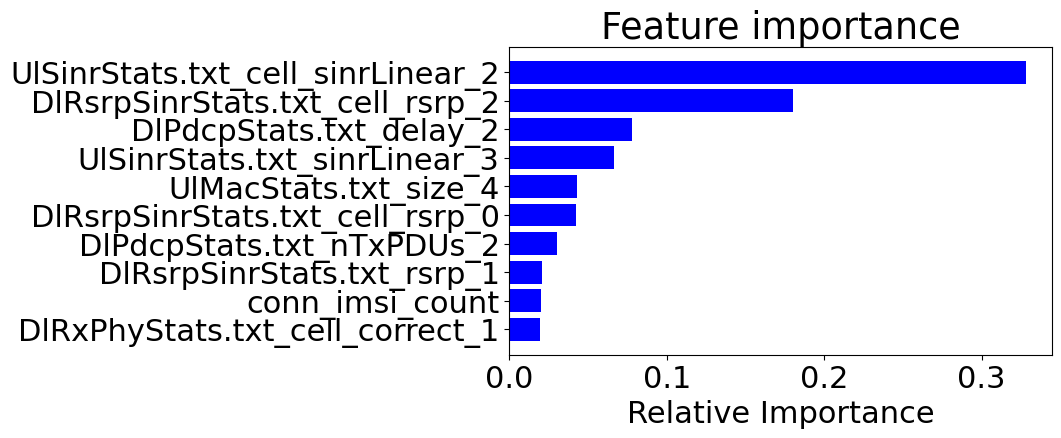

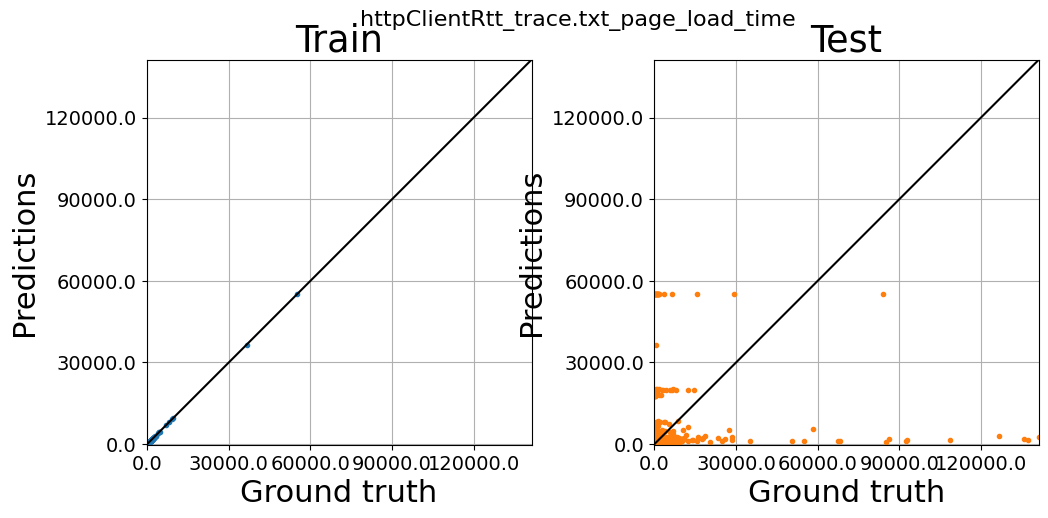



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_ul_delay
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(1185438, 470)
(511126, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  308
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  291
After Imputing: Number of cols with NaNs in the data:  0
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [1163420    4685    2477    1690    1311]
After removing bins that are not populated enough
[0 1 2 3 4] [1163420    4685    2477    1690    1311]
(1163420, 460)
(

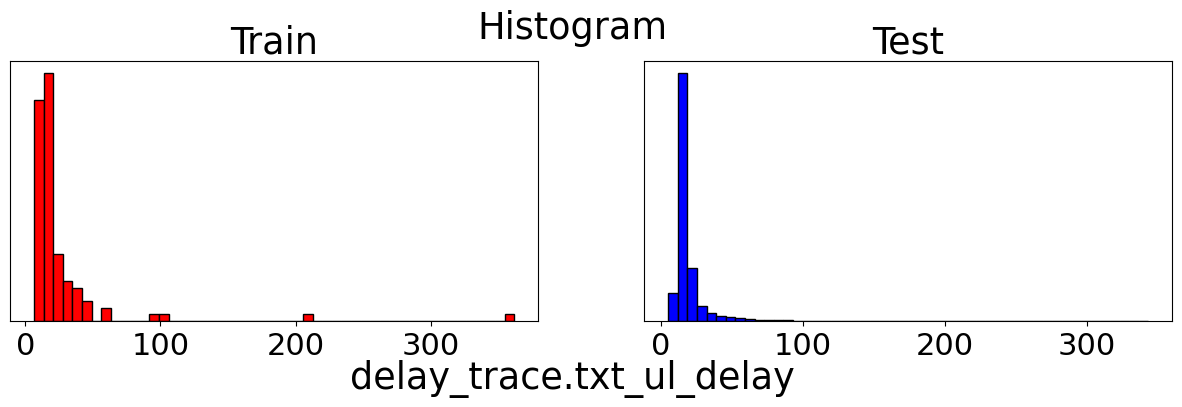

Time to train model:  2.976621627807617


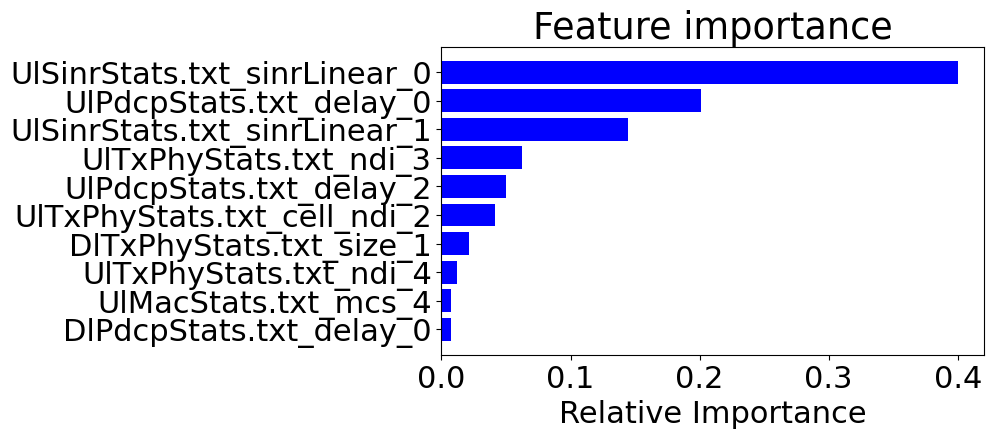

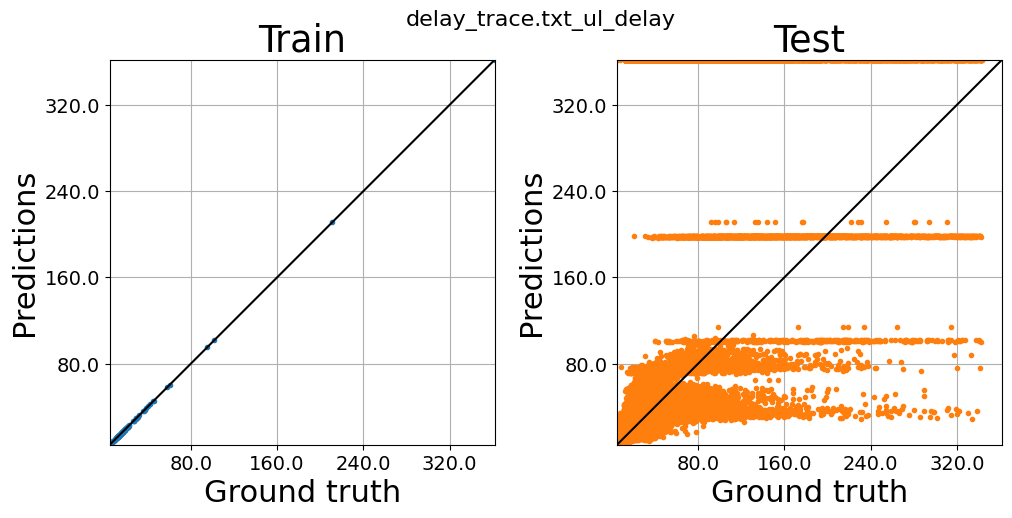



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_dl_delay
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(1258061, 470)
(539372, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  230
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  230
After Imputing: Number of cols with NaNs in the data:  0
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [1158085   50040   21018   10251    6089]
After removing bins that are not populated enough
[0 1 2 3 4] [1158085   50040   21018   10251    6089]
(1229143, 460)
(

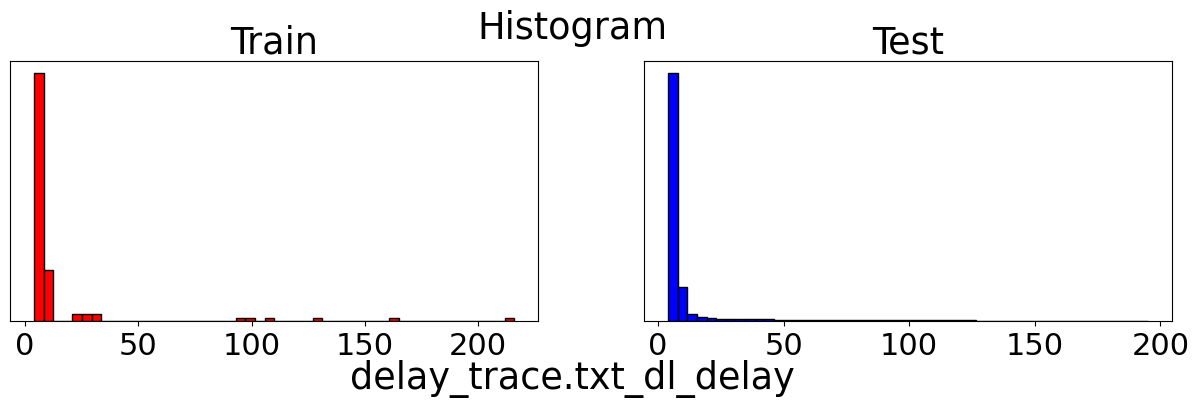

Time to train model:  3.1528286933898926


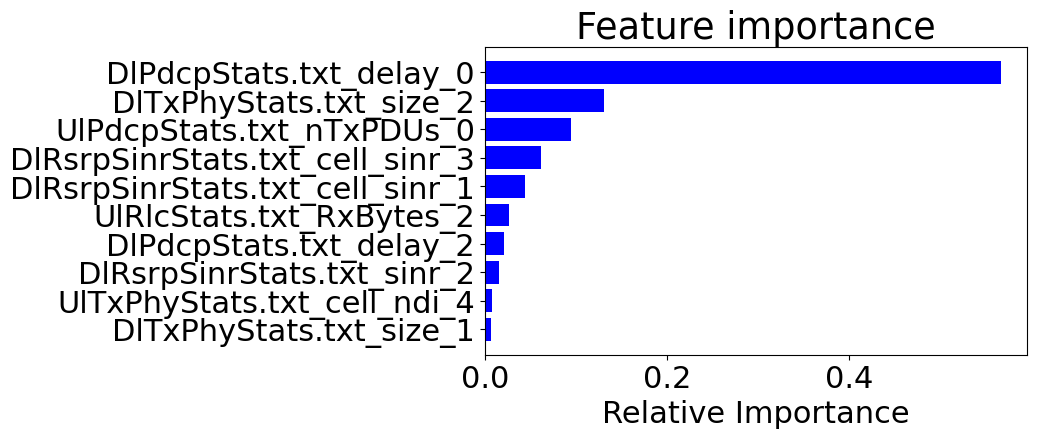

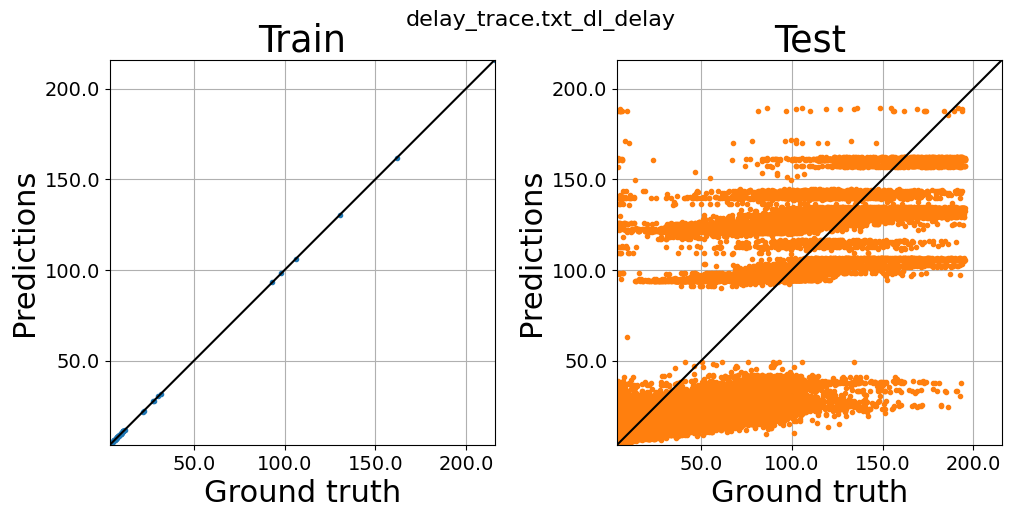



===============================  DONE  ===================================================
# train runs used  7
# test runs used  3
Concatenating runs:  [13 16 19 11 17 20 14]
Loaded run 13
Loaded run 16
Loaded run 19
Loaded run 11
Loaded run 17
Loaded run 20
Loaded run 14
(1259370, 470)
Concatenating runs:  [15 18 12]
Loaded run 15
Loaded run 18
Loaded run 12
(539730, 470)
Learning task:  dashClient_trace.txt_newBitRate_bps
clas
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(44771, 470)
(18653, 470)
(array([  45000,   89000,  131000,  178000,  221000,  263000,  334000,
        396000,  522000,  595000,  791000, 1033000, 1245000, 1547000,
       2134000, 2484000, 3079000, 3527000, 3840000]), array([   68,    29,    44,    45,    52,    65,    82,   161,   114,
         366,   524,   464,   636,  1578,   945,  1810,  1418,   745,
       35625]))
(array([0, 1, 2]), array([ 2650,  4333, 37788]))
(array([  45000,   8900

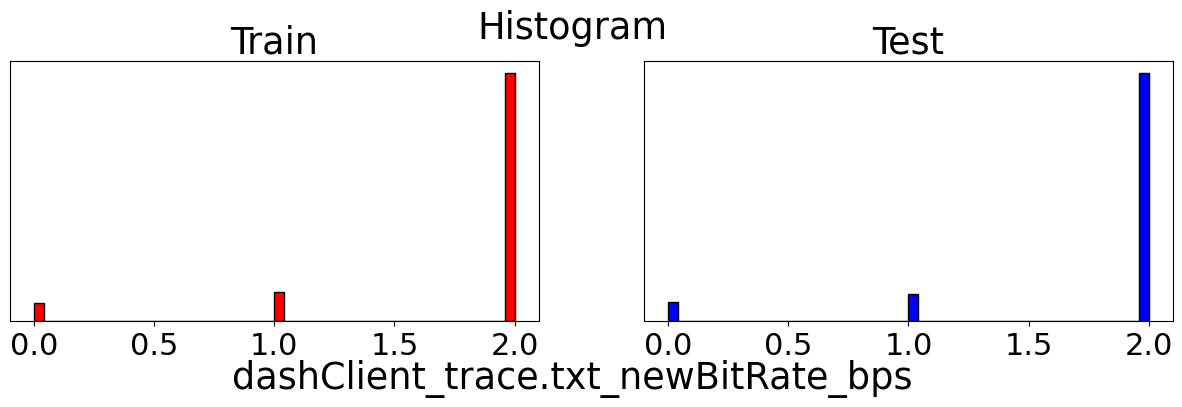

Time to train model:  0.705331563949585


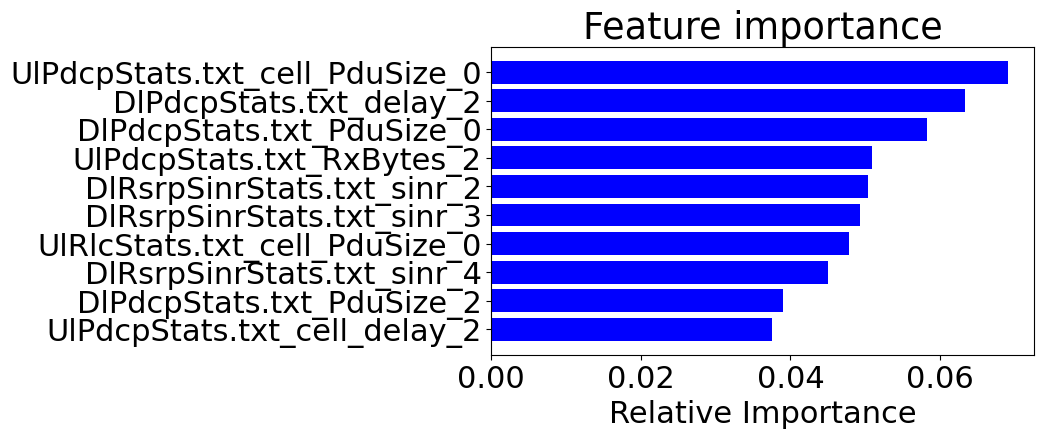

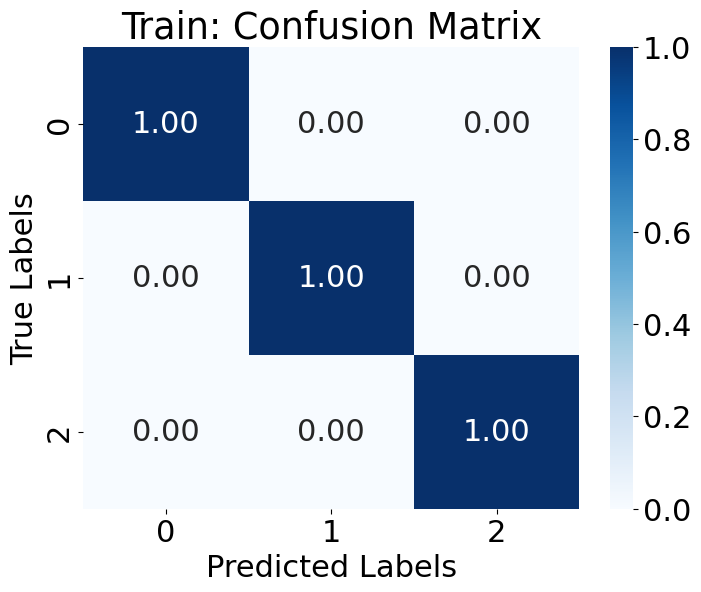

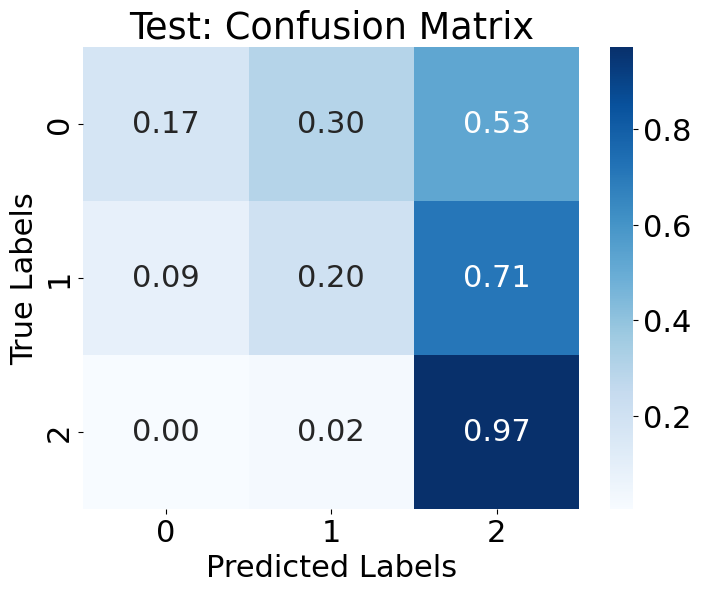



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_frag_thput_mbps
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(23089, 470)
(9897, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  176
After Imputing: Number of cols with NaNs in the data:  8
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [15488  1936  1918  2406  1110]
After removing bins that are not populated enough
[0 1 2 3 4] [15488  1936  1918  2406  1110]
(22858, 460)
(22858,)
(22858,)
bin_and_remove_outliers
Before removing bins

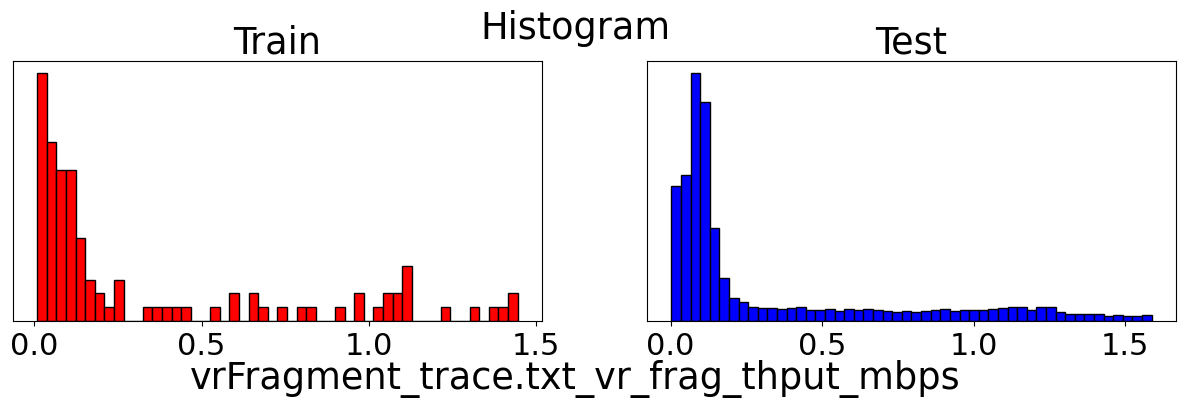

Time to train model:  0.41570281982421875


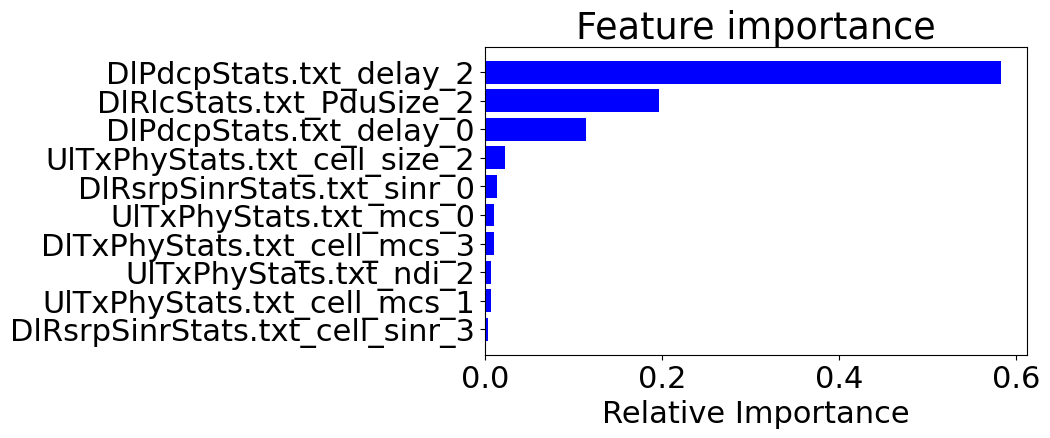

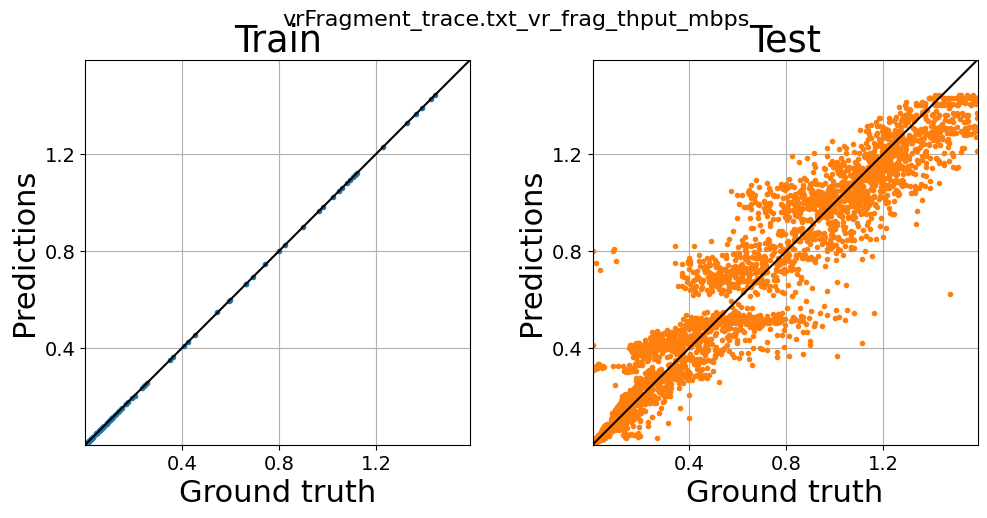



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_thput_mbps
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(23062, 470)
(9889, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  170
After Imputing: Number of cols with NaNs in the data:  8
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [15599  1915  2028  2231  1058]
After removing bins that are not populated enough
[0 1 2 3 4] [15599  1915  2028  2231  1058]
(22831, 460)
(22831,)
(22831,)
bin_and_remove_outliers
Before removing bin

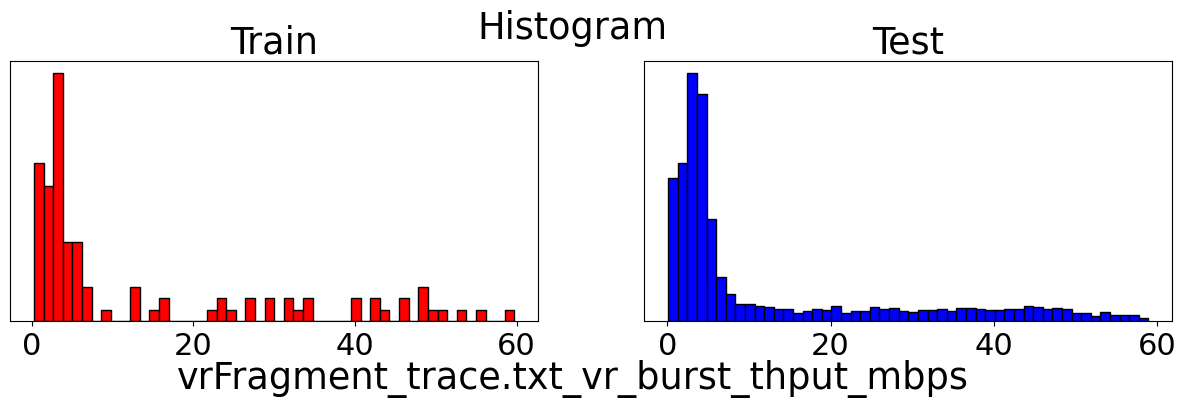

Time to train model:  0.5841555595397949


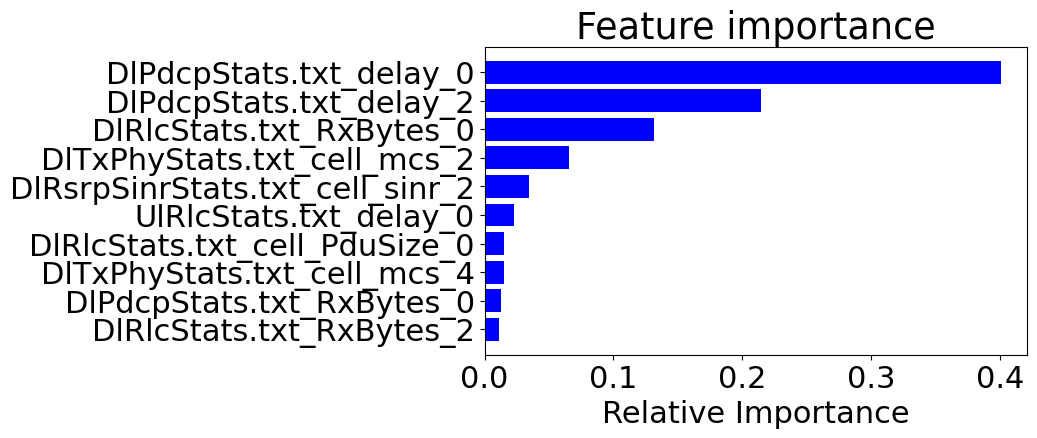

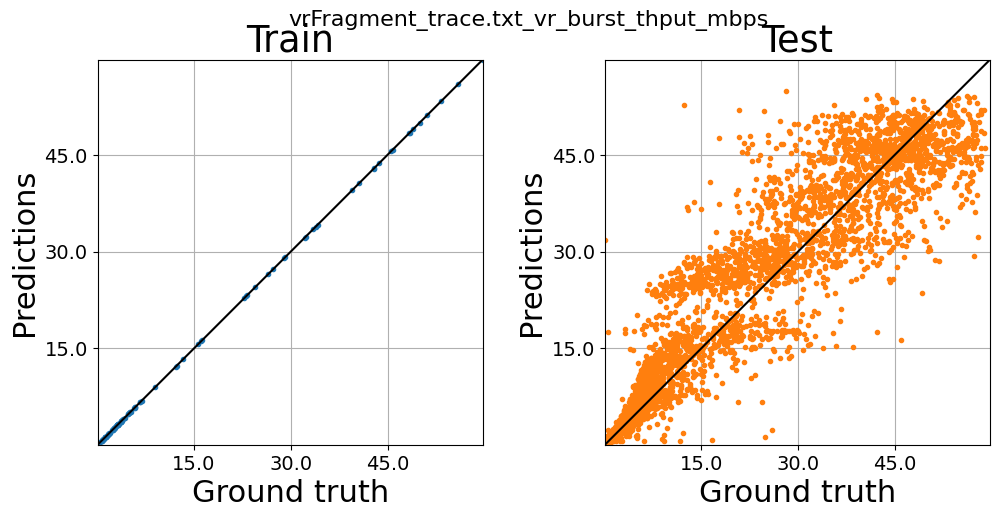



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_frag_time
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(23089, 470)
(9897, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  176
After Imputing: Number of cols with NaNs in the data:  8
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [18121  2884  1097   501   255]
After removing bins that are not populated enough
[0 1 2 3 4] [18121  2884  1097   501   255]
(22858, 460)
(22858,)
(22858,)
bin_and_remove_outliers
Before removing bins that 

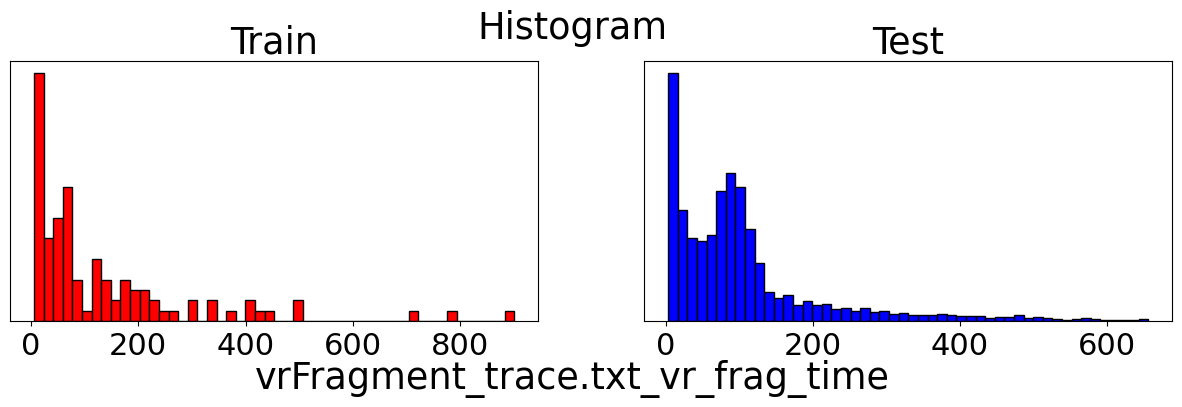

Time to train model:  0.6520712375640869


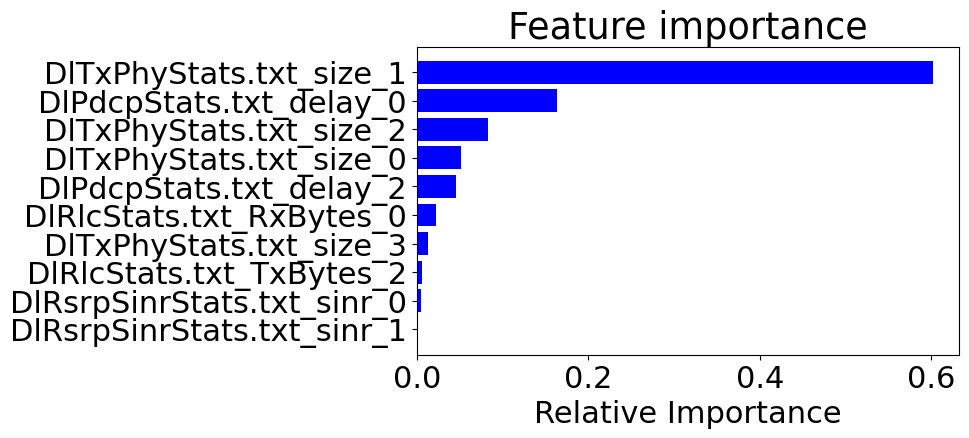

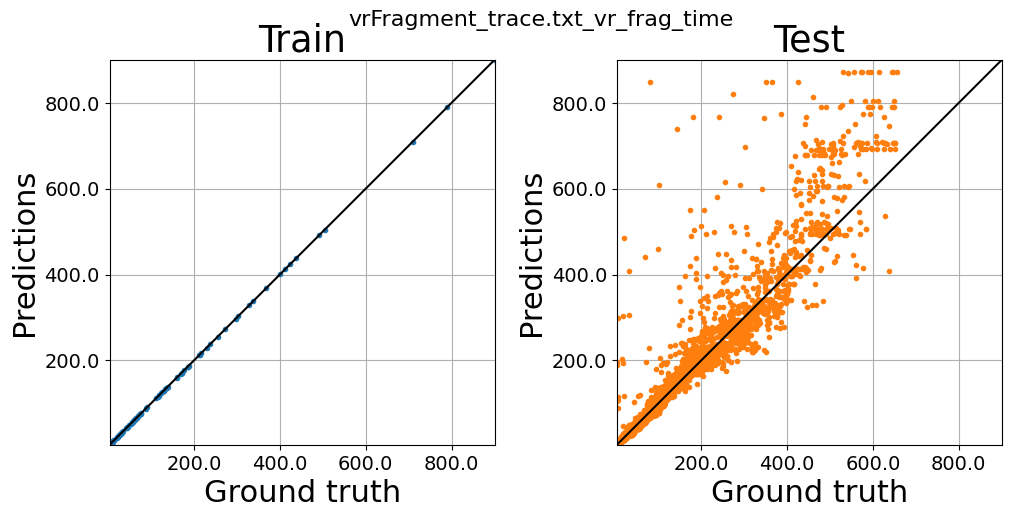



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_time
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(23062, 470)
(9889, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  170
After Imputing: Number of cols with NaNs in the data:  8
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [18060  2884  1133   496   258]
After removing bins that are not populated enough
[0 1 2 3 4] [18060  2884  1133   496   258]
(22831, 460)
(22831,)
(22831,)
bin_and_remove_outliers
Before removing bins that

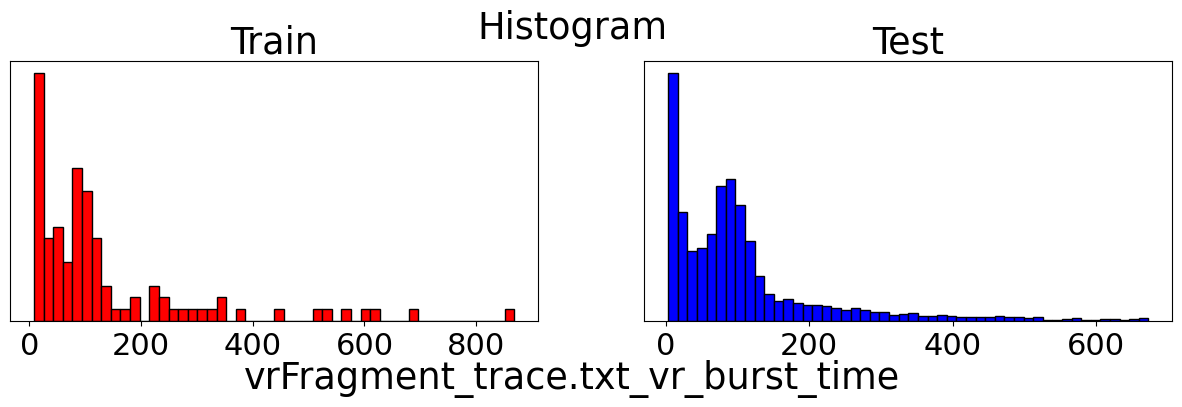

Time to train model:  0.6528615951538086


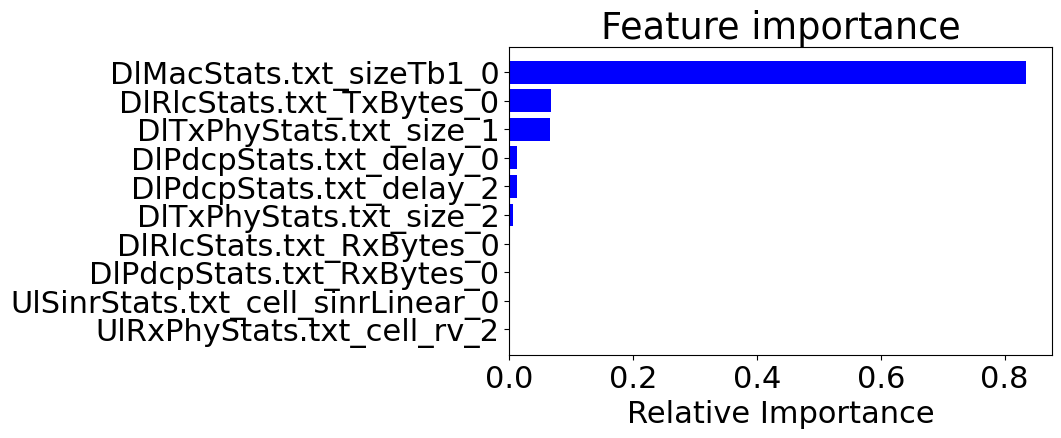

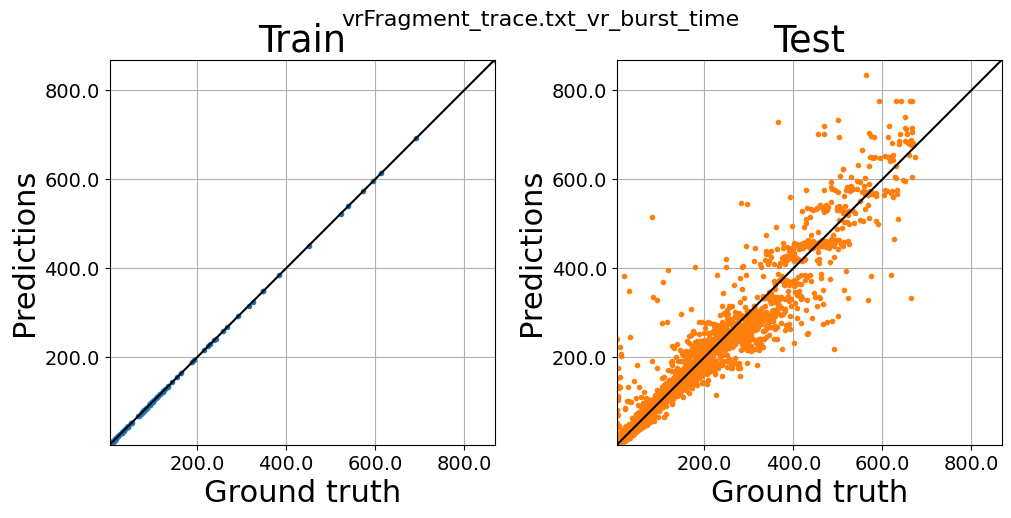



===============================  DONE  ===================================================
Learning task:  httpClientRtt_trace.txt_page_load_time
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(3086, 470)
(1438, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  78
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  151
After Imputing: Number of cols with NaNs in the data:  27
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [2977   16   22   21   19]
After removing bins that are not populated enough
[0 1 2 3 4] [2977   16   22   21   19]
(2977, 460)
(2977,)
(2977,)
bin_and_remove_outliers
Before removing bins that are not p

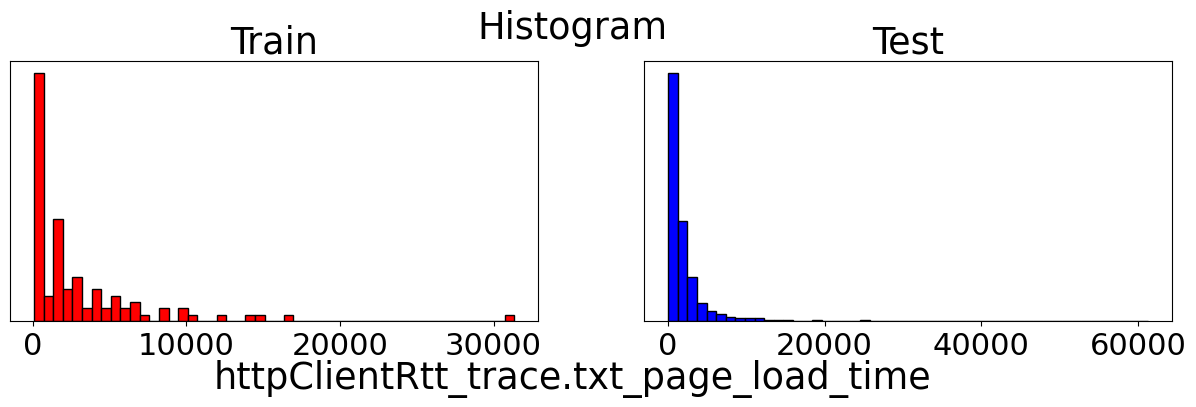

Time to train model:  0.8891603946685791


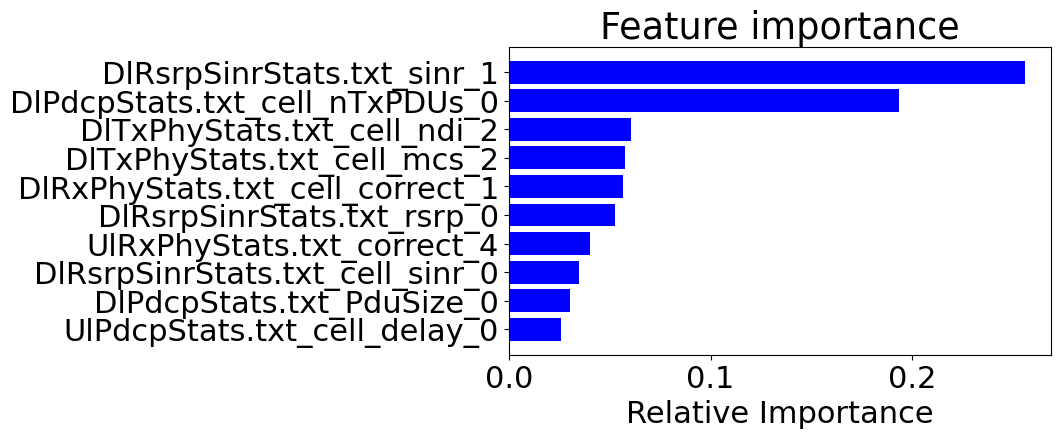

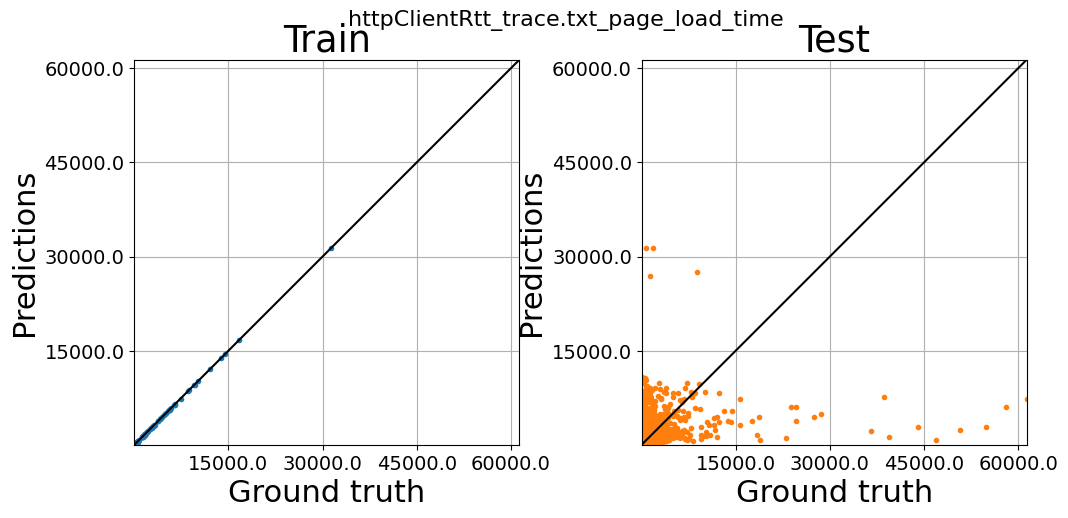



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_ul_delay
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(1190180, 470)
(506384, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  308
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  305
After Imputing: Number of cols with NaNs in the data:  0
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [1168214    4798    2377    1632    1257]
After removing bins that are not populated enough
[0 1 2 3 4] [1168214    4798    2377    1632    1257]
(1168214, 460)
(

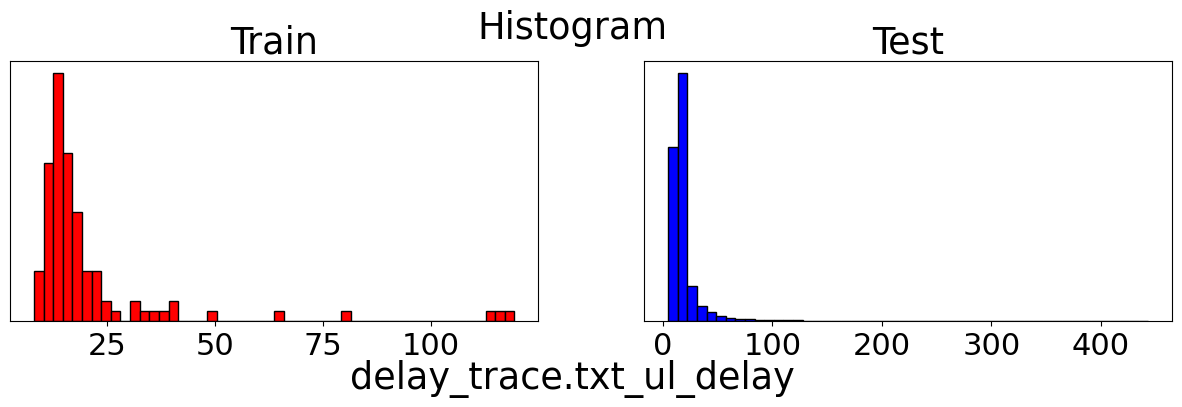

Time to train model:  2.892547607421875


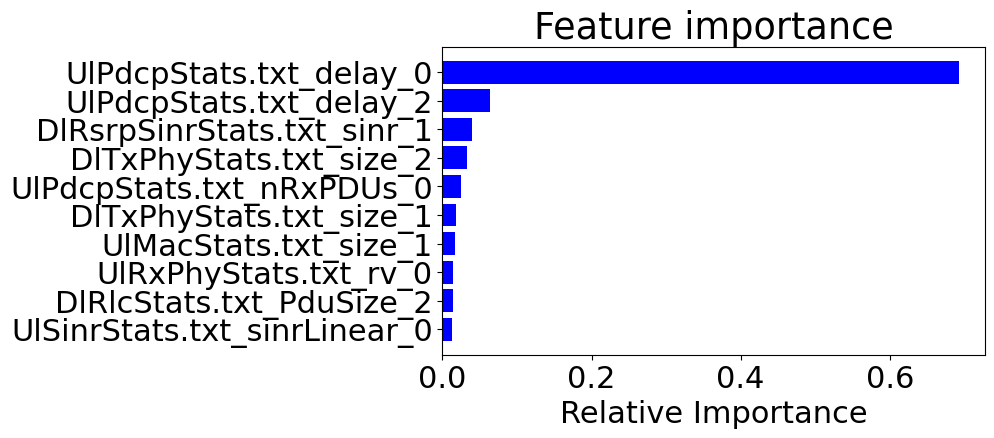

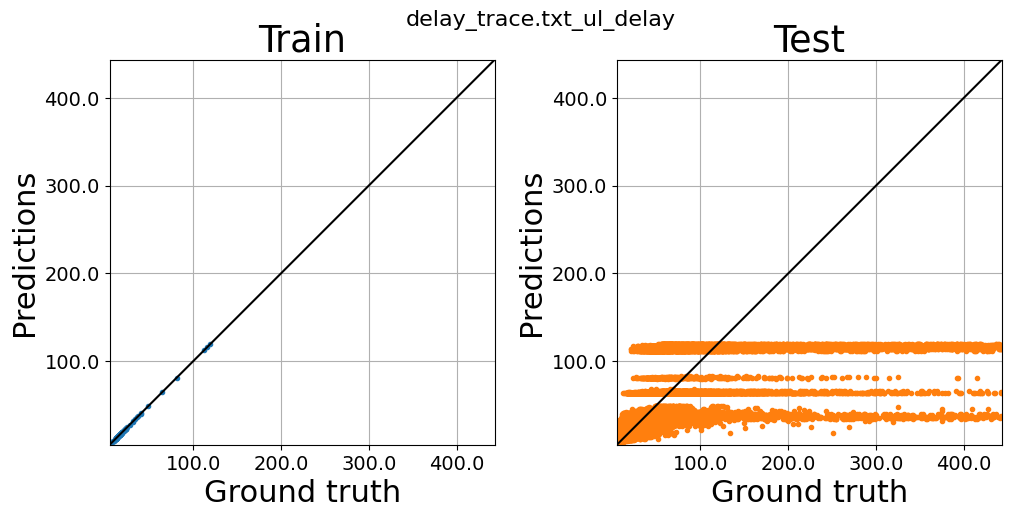



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_dl_delay
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(1258167, 470)
(539266, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  230
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  230
After Imputing: Number of cols with NaNs in the data:  0
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [1156831   50925   21359   10326    6144]
After removing bins that are not populated enough
[0 1 2 3 4] [1156831   50925   21359   10326    6144]
(1229115, 460)
(

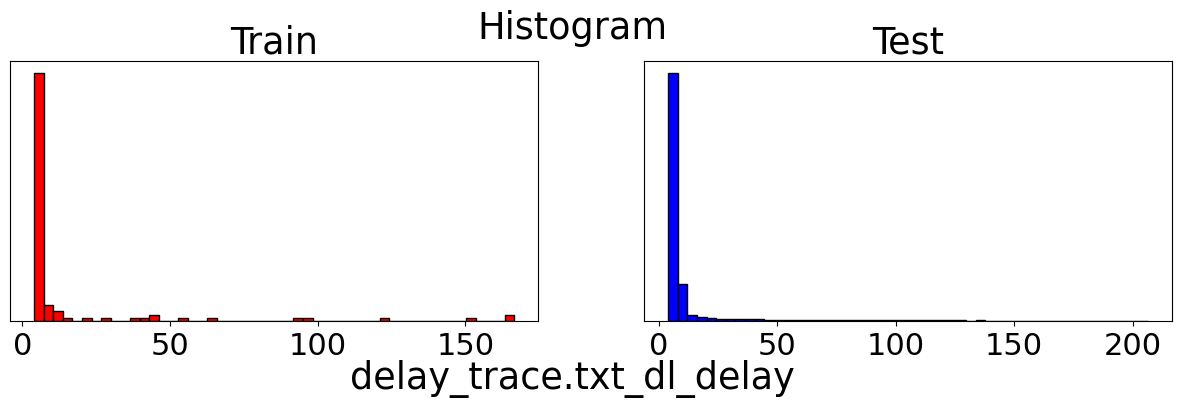

Time to train model:  3.0001766681671143


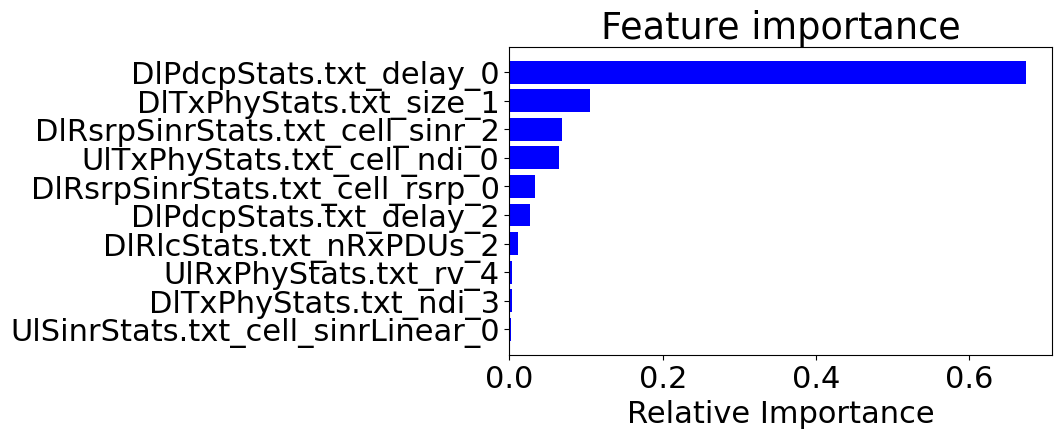

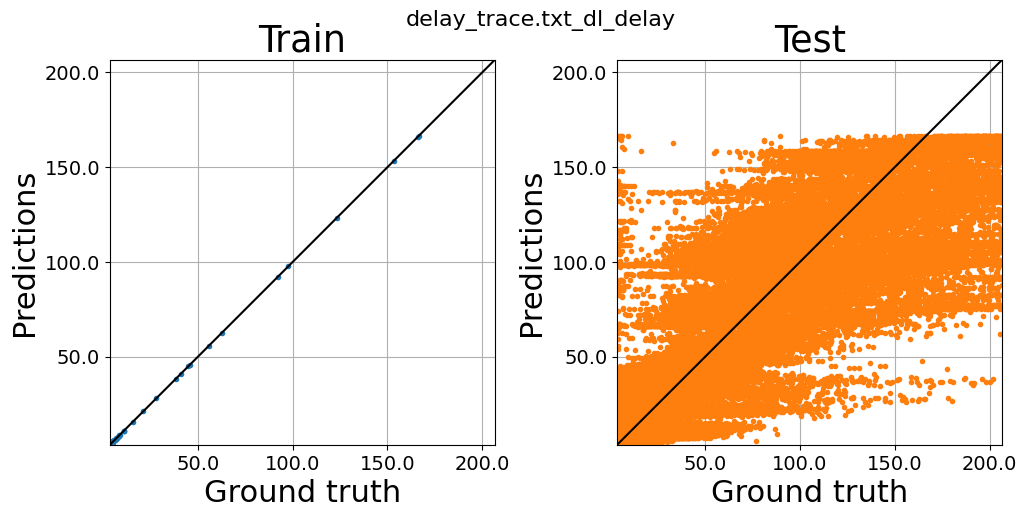



===============================  DONE  ===================================================
============================= Train set mean over runs ===================================
                                               MAE          MAPE        R2
dashClient_trace.txt_newBitRate_bps       1.000000  1.000000e+00  1.000000
vrFragment_trace.txt_vr_frag_thput_mbps   0.000247  4.004188e-03  0.999999
vrFragment_trace.txt_vr_burst_thput_mbps  0.000282  1.183108e-04  1.000000
vrFragment_trace.txt_vr_frag_time         0.000291  8.485190e-06  1.000000
vrFragment_trace.txt_vr_burst_time        0.000300  9.445980e-06  1.000000
httpClientRtt_trace.txt_page_load_time    0.000564  8.043491e-07  1.000000
delay_trace.txt_ul_delay                  0.000293  1.842909e-05  1.000000
delay_trace.txt_dl_delay                  0.000311  5.493354e-05  1.000000
=============================== Test set results =========================================
                                                  

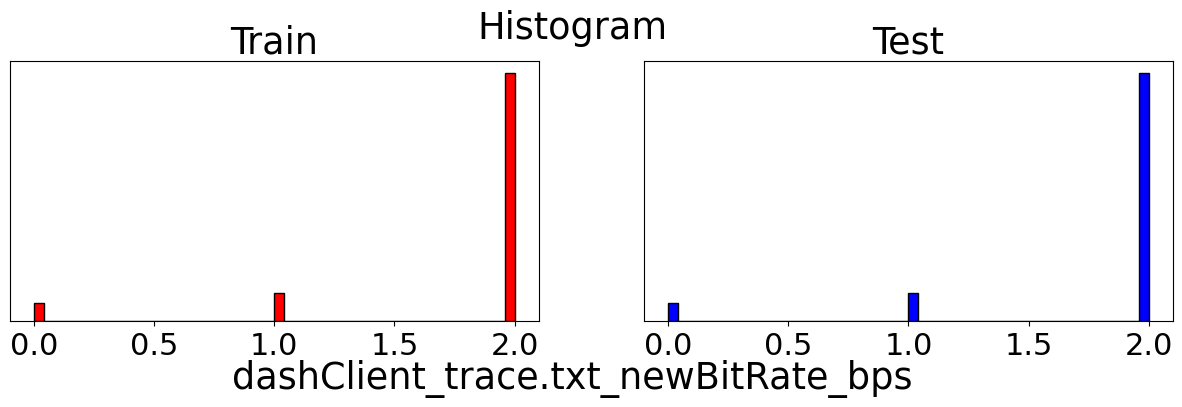

Time to train model:  3.5696210861206055


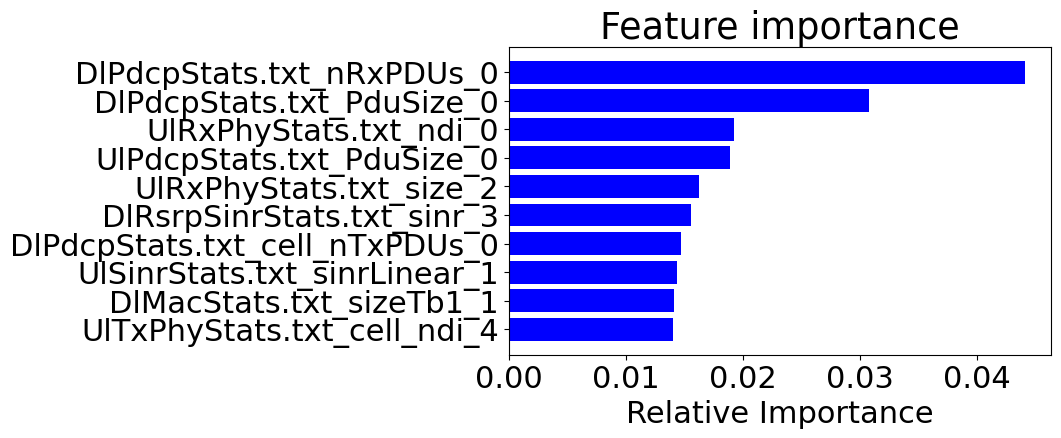

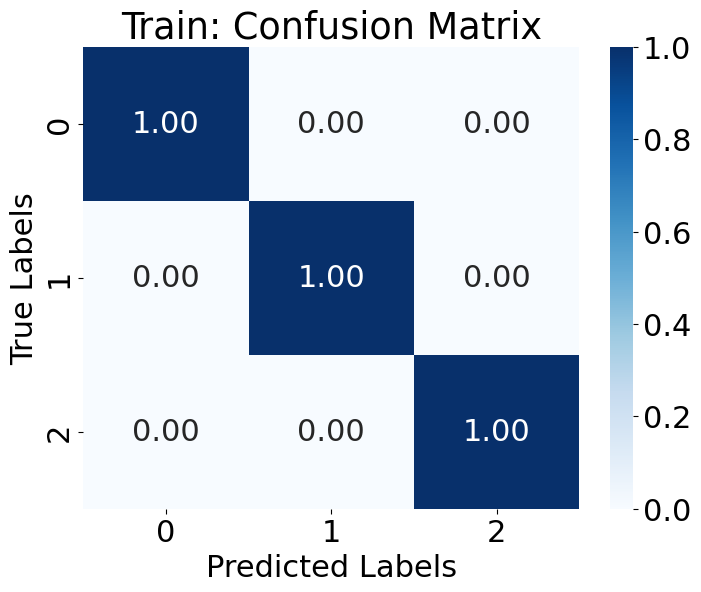

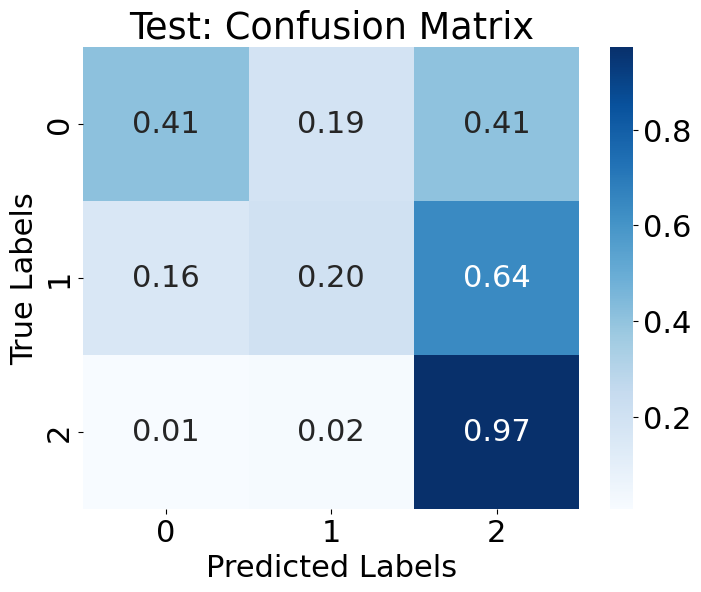



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_frag_thput_mbps
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(23103, 470)
(9883, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  8
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  0
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [15158  1993  1957  2562  1201]
After removing bins that are not populated enough
[0 1 2 3 4] [15158  1993  1957  2562  1201]
(22871, 460)
(22871,)
(22871,)
bin_and_remove_outliers
Before removing bins

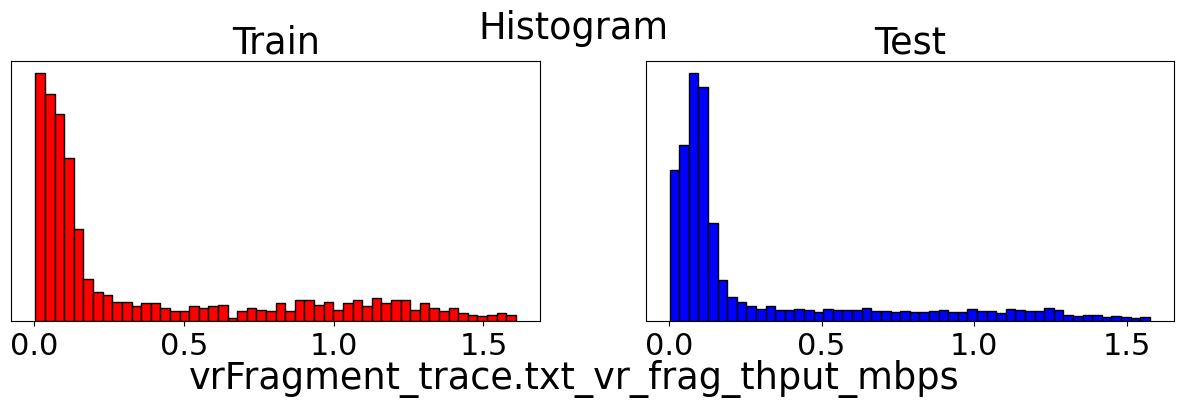

Time to train model:  1.8772547245025635


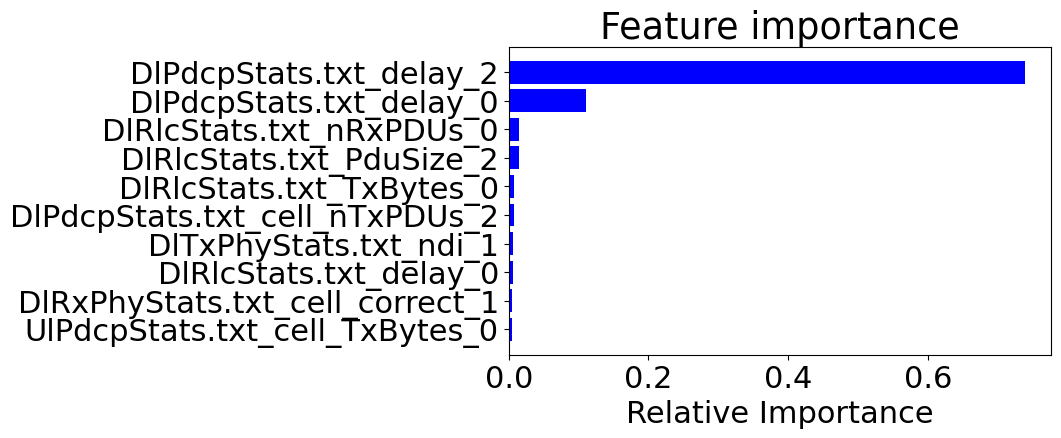

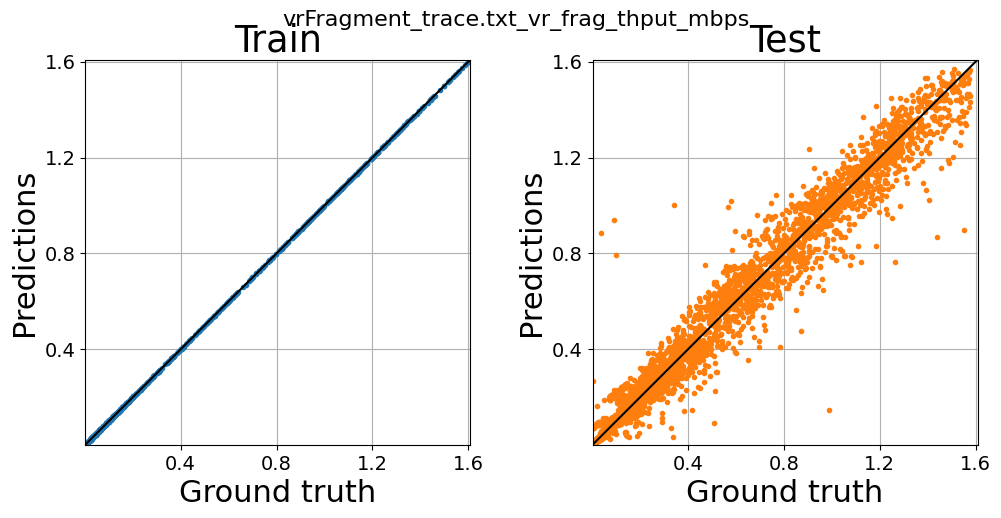



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_thput_mbps
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(23074, 470)
(9877, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  8
Before Imputing: Number of cols with NaNs in the data:  175
After Imputing: Number of cols with NaNs in the data:  0
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [15272  1968  2096  2383  1124]
After removing bins that are not populated enough
[0 1 2 3 4] [15272  1968  2096  2383  1124]
(22843, 460)
(22843,)
(22843,)
bin_and_remove_outliers
Before removing bin

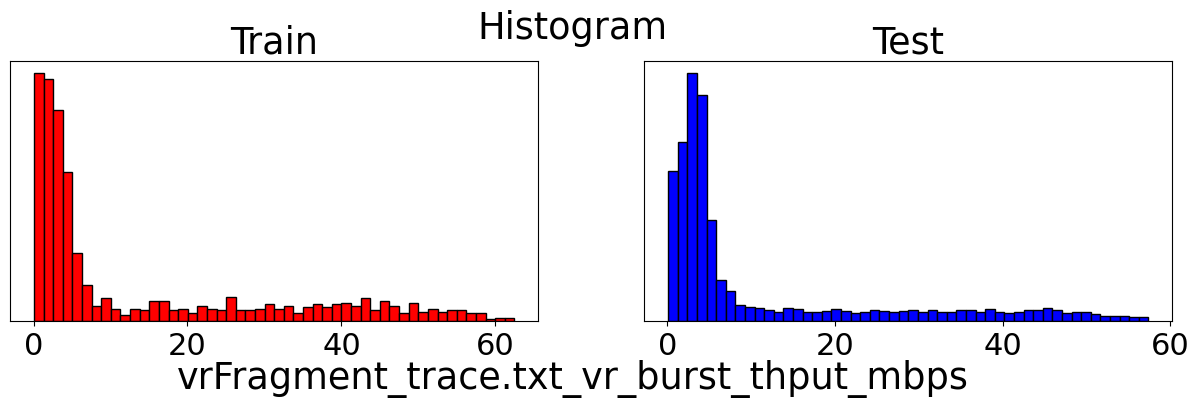

Time to train model:  2.7649219036102295


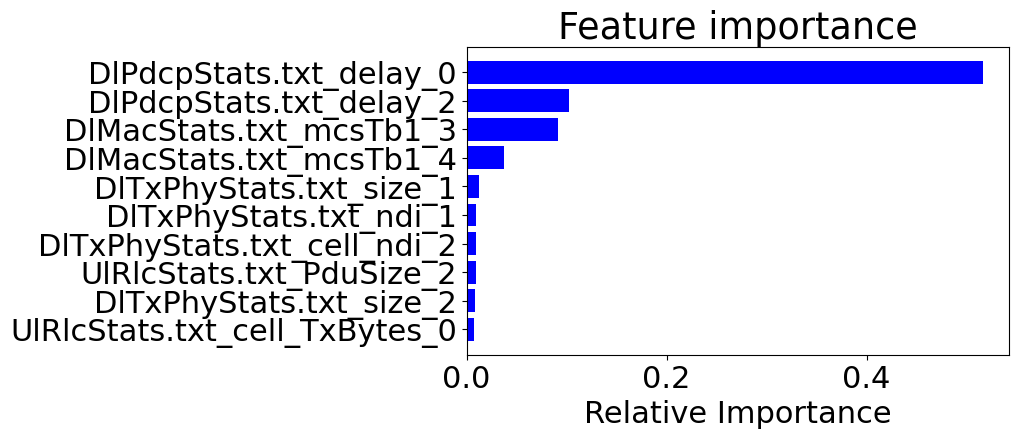

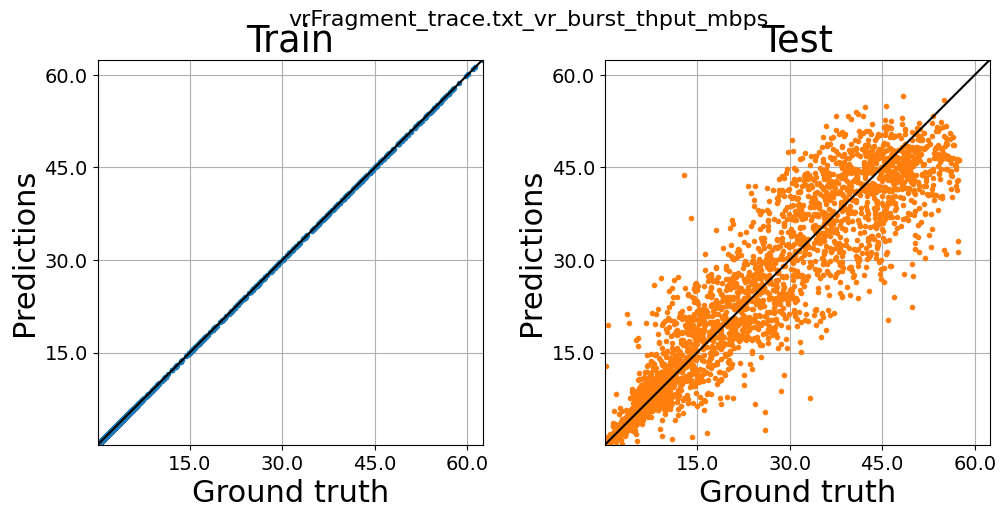



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_frag_time
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(23103, 470)
(9883, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  8
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  0
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [18246  2836  1073   487   229]
After removing bins that are not populated enough
[0 1 2 3 4] [18246  2836  1073   487   229]
(22642, 460)
(22642,)
(22642,)
bin_and_remove_outliers
Before removing bins that 

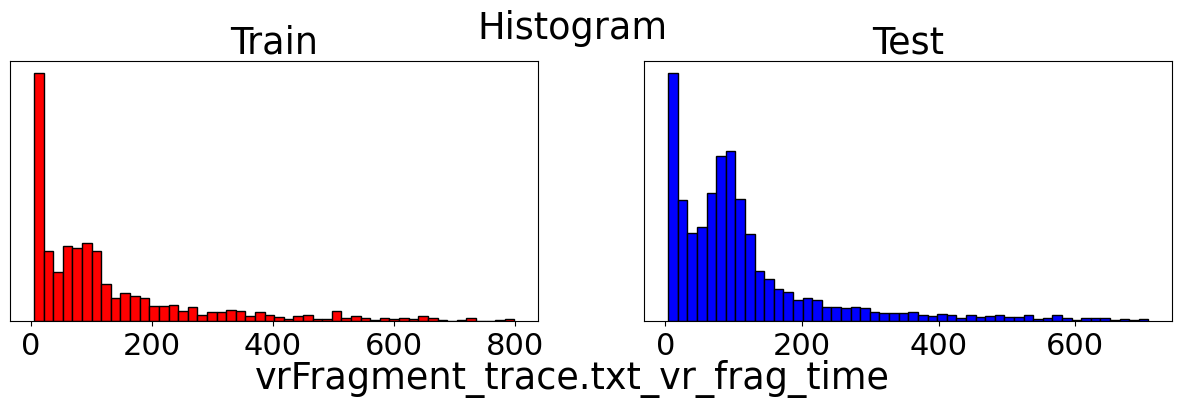

Time to train model:  2.7135181427001953


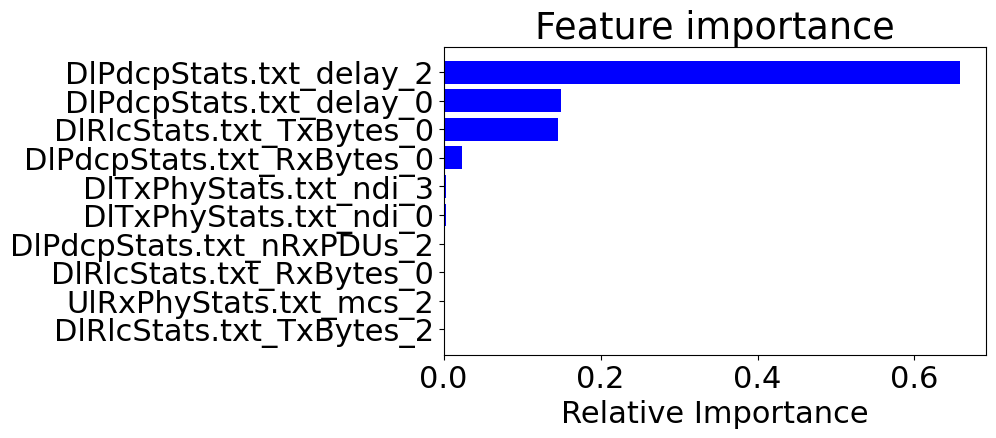

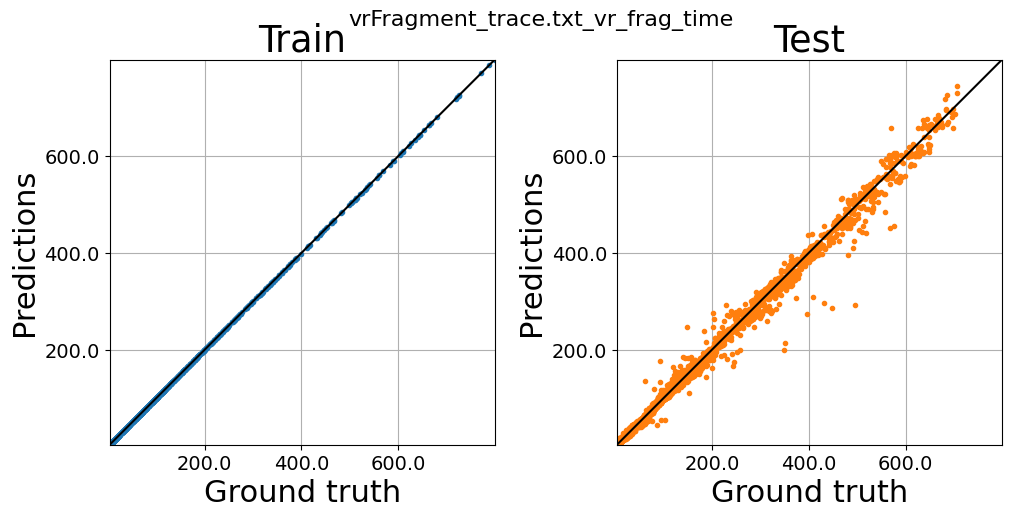



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_time
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(23074, 470)
(9877, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  178
After Imputing: Number of cols with NaNs in the data:  8
Before Imputing: Number of cols with NaNs in the data:  175
After Imputing: Number of cols with NaNs in the data:  0
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [18155  2861  1107   486   234]
After removing bins that are not populated enough
[0 1 2 3 4] [18155  2861  1107   486   234]
(22843, 460)
(22843,)
(22843,)
bin_and_remove_outliers
Before removing bins that

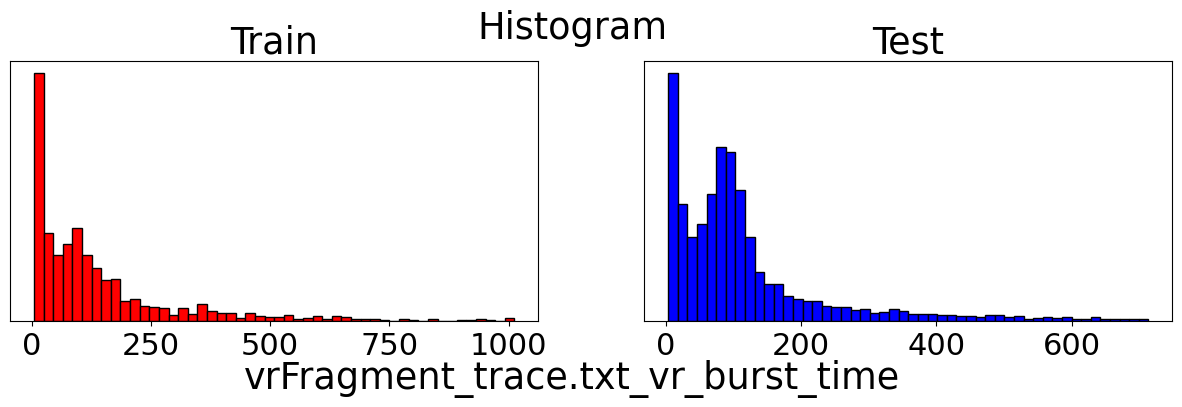

Time to train model:  2.757455348968506


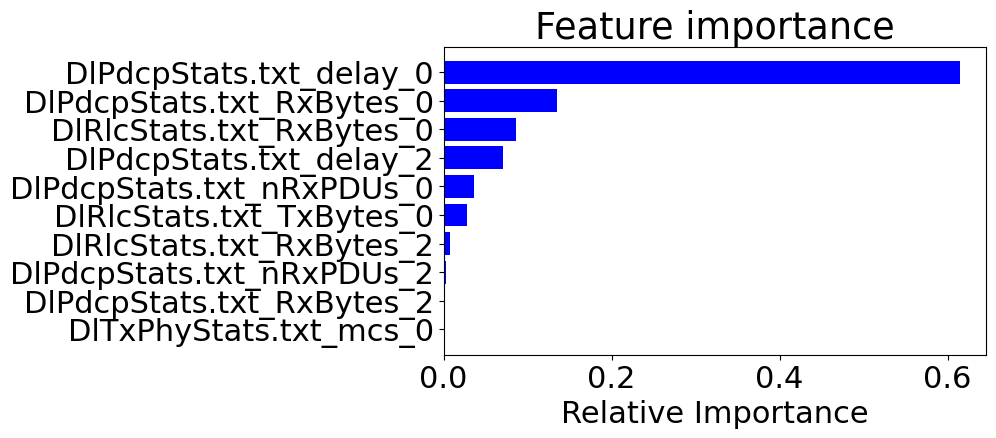

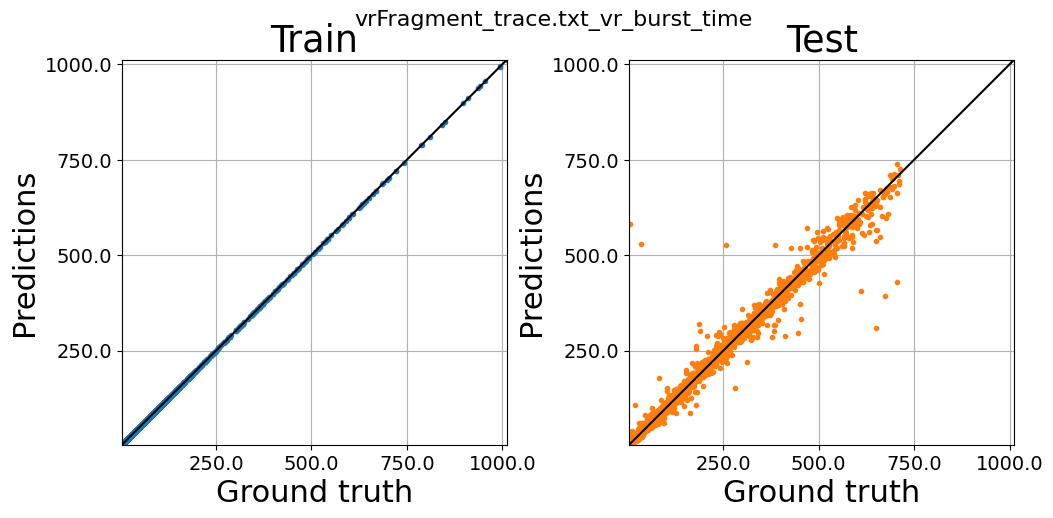



===============================  DONE  ===================================================
Learning task:  httpClientRtt_trace.txt_page_load_time
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(3124, 470)
(1400, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  78
After Imputing: Number of cols with NaNs in the data:  27
Before Imputing: Number of cols with NaNs in the data:  151
After Imputing: Number of cols with NaNs in the data:  0
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [3015   17   20   21   19]
After removing bins that are not populated enough
[0 1 2 3 4] [3015   17   20   21   19]
(3015, 460)
(3015,)
(3015,)
bin_and_remove_outliers
Before removing bins that are not p

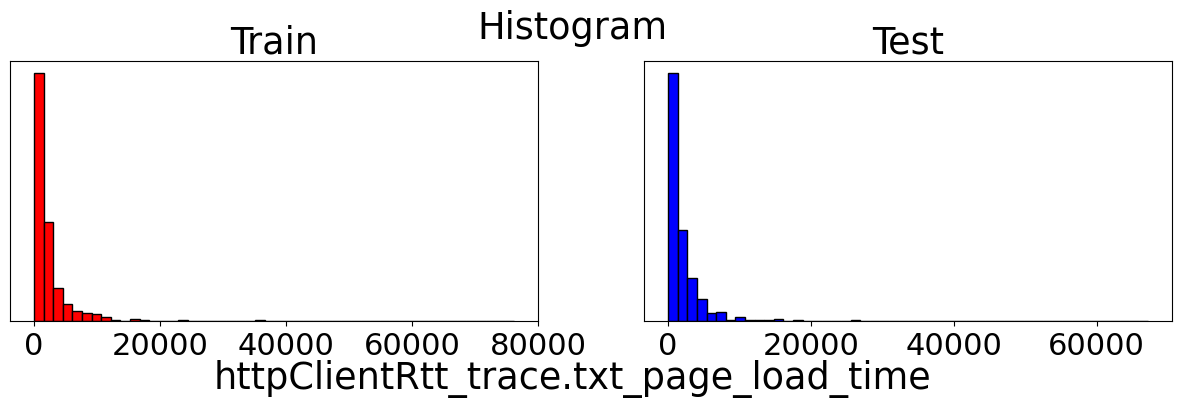

Time to train model:  3.093658447265625


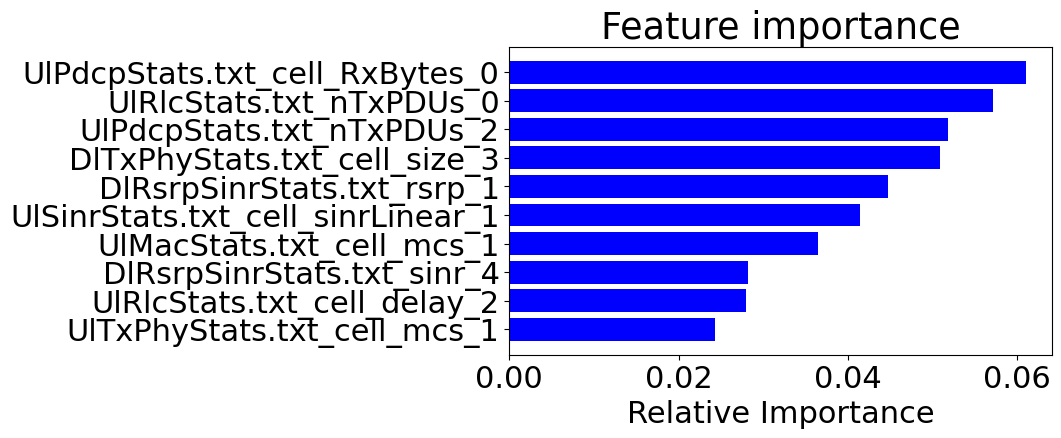

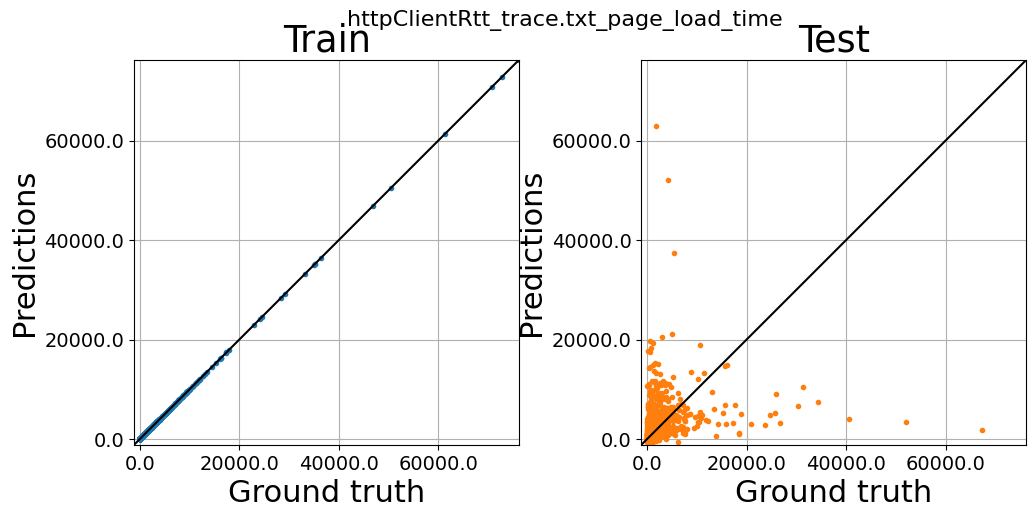



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_ul_delay
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(1190366, 470)
(506198, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  308
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  291
After Imputing: Number of cols with NaNs in the data:  0
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [1168645    4685    2317    1612    1203]
After removing bins that are not populated enough
[0 1 2 3 4] [1168645    4685    2317    1612    1203]
(1168645, 460)
(

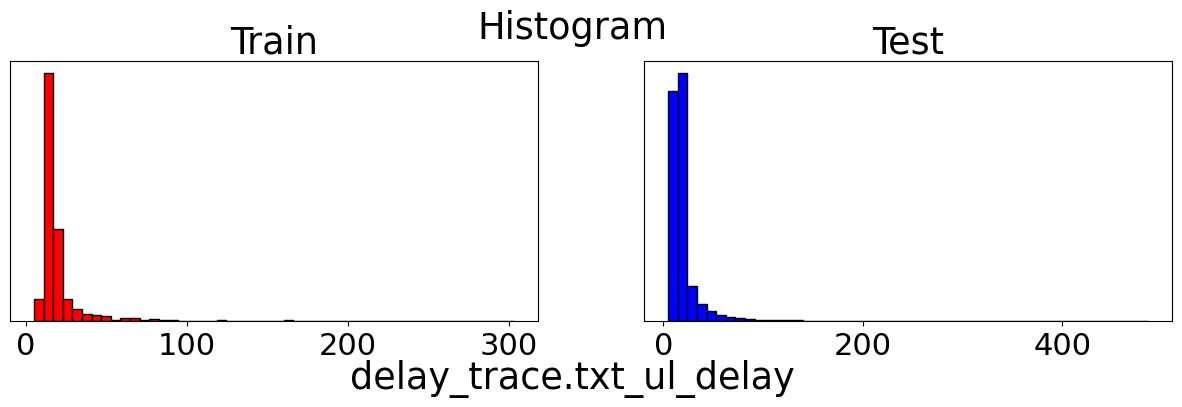

Time to train model:  4.844932317733765


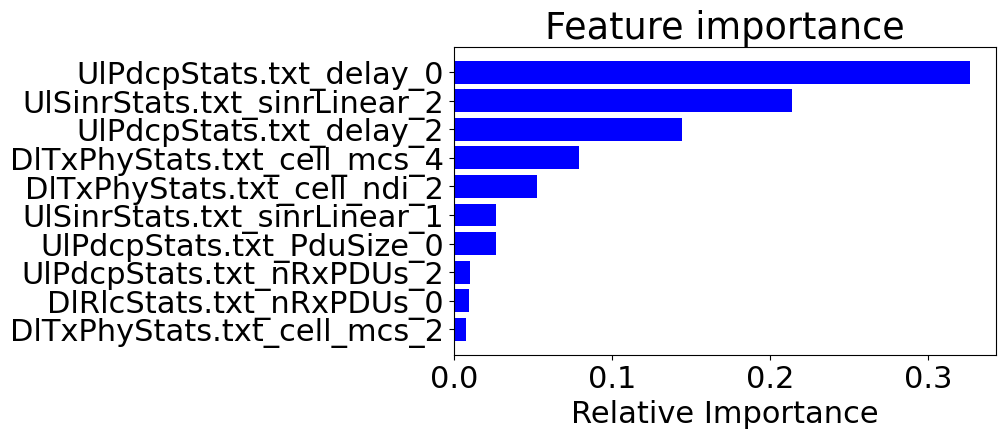

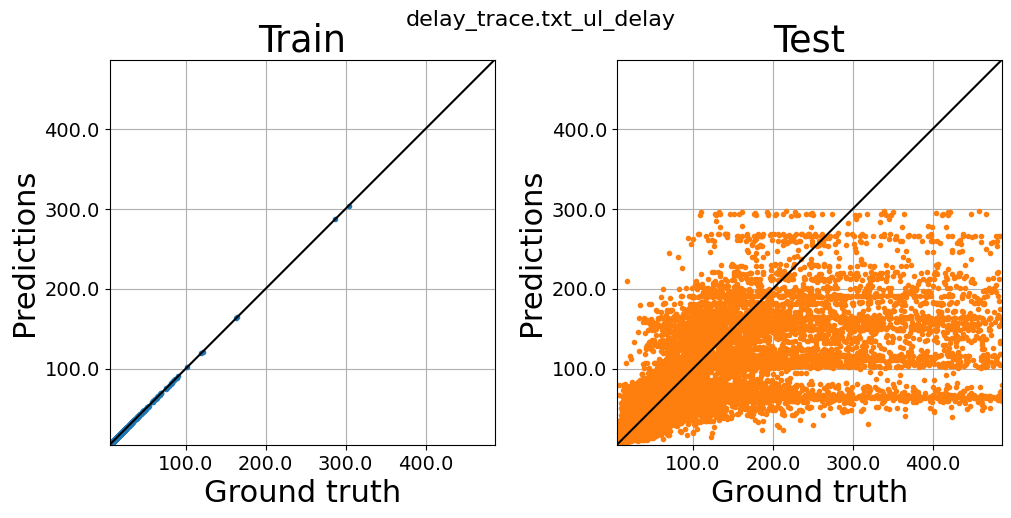



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_dl_delay
reg
(1259370, 470)
(539730, 470)
Dropping rows for which the learning_task label is NA, since there is no ground truth
(1258140, 470)
(539293, 470)
Imputing Train and Test set NaNs in input features with method  forward_fill
Before Imputing: Number of cols with NaNs in the data:  230
After Imputing: Number of cols with NaNs in the data:  0
Before Imputing: Number of cols with NaNs in the data:  230
After Imputing: Number of cols with NaNs in the data:  0
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [1158341   50003   20963   10243    6008]
After removing bins that are not populated enough
[0 1 2 3 4] [1158341   50003   20963   10243    6008]
(1229307, 460)
(

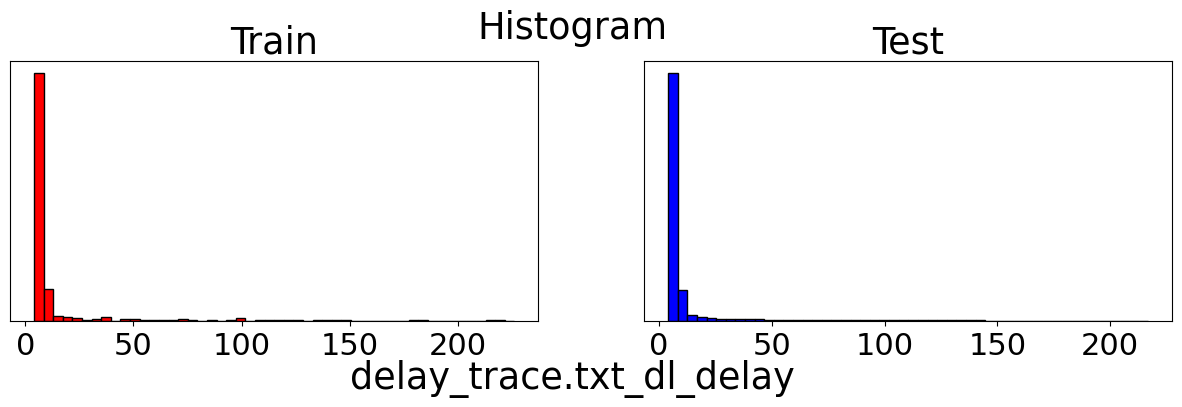

Time to train model:  5.030404567718506


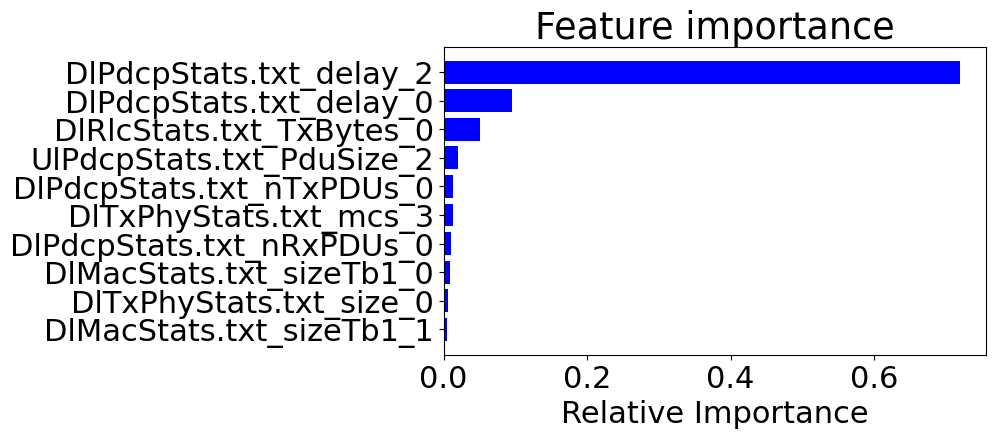

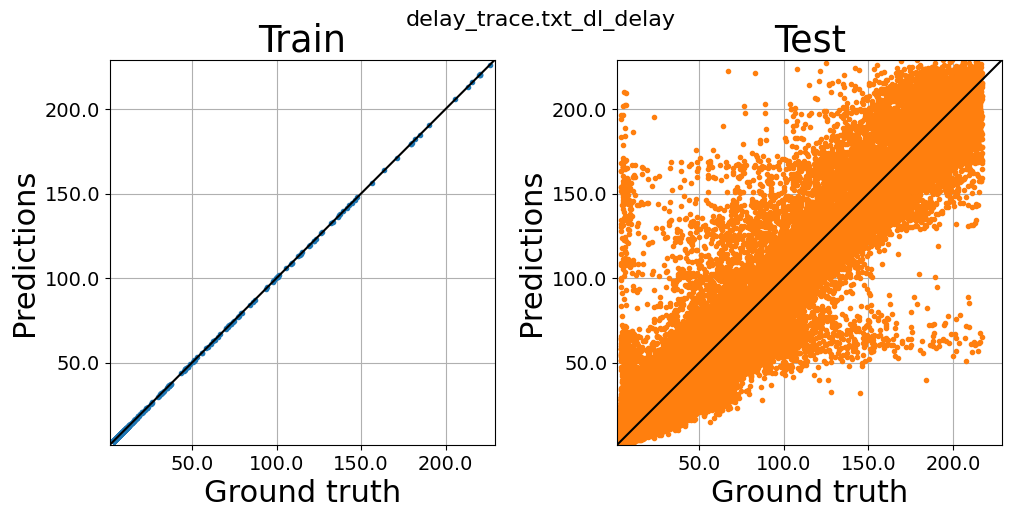



===============================  DONE  ===================================================
# train runs used  7
# test runs used  3
Concatenating runs:  [15 13 20 12 19 16 14]
Loaded run 15
Loaded run 13
Loaded run 20
Loaded run 12
Loaded run 19
Loaded run 16
Loaded run 14
(1259370, 470)
Concatenating runs:  [17 18 11]
Loaded run 17
Loaded run 18


In [ ]:
open('train_results.csv', 'w').close()
open('test_results.csv', 'w').close()

# Iterate over different number of labeled samples 
for label_no in num_samples_list:
    EXP_PARAM['label_no'] = label_no
    print('==========================================================================')
    print('Num. labeled samples: ', label_no)

    # Aggregate results over runs
    #train_results = pd.DataFrame(index=learning_tasks, columns=['model MAE', 'baseline1 MAE', 'baseline2 MAE', 'model MAPE', 'baseline1 MAPE', 'baseline2 MAPE'])
    #test_results = pd.DataFrame(index=learning_tasks, columns=['model MAE', 'baseline1 MAE', 'baseline2 MAE', 'model MAPE', 'baseline1 MAPE', 'baseline2 MAPE'])
    train_results = pd.DataFrame(index=learning_tasks, columns=['MAE', 'MAPE', 'R2']) # or ['ACC', 'F1', 'ROC_AUC']
    test_results = pd.DataFrame(index=learning_tasks, columns=['MAE', 'MAPE', 'R2']) # or ['ACC', 'F1', 'ROC_AUC']
    
    # Apply the function to each cell in the DataFrame
    train_results = train_results.applymap(lambda x: create_nan_array(EXP_PARAM['num_rand_runs']))
    test_results = test_results.applymap(lambda x: create_nan_array(EXP_PARAM['num_rand_runs']))
    
    for rs in range(0, EXP_PARAM['num_rand_runs']):
        
        # Read the data 
        shuffled_run_ind = np.random.permutation(len(train_test_run_nums))
        train_runs = train_test_run_nums[shuffled_run_ind[:num_train_runs]]
        test_runs = train_test_run_nums[shuffled_run_ind[num_train_runs:]]
        print('# train runs used ', len(train_runs))
        print('# test runs used ', len(test_runs))
        #==============================================
        train_data = read_and_concatenate_runs(train_runs, dataset_folder, train_slice, network_info, time_step_size, use_all_feats, drop_col_substr)
        test_data = read_and_concatenate_runs(test_runs, dataset_folder, test_slice, network_info, time_step_size, use_all_feats, drop_col_substr)
        # Add a feature with cell_conn_type as a featurte that indicates whether it is macro or micro cell 
        train_data = add_cell_type_as_feature(train_data, network_info)
        test_data = add_cell_type_as_feature(test_data, network_info)
        
        for idx, learning_task in enumerate(learning_tasks):
            
            print('================================================================================')
            print('Learning task: ', learning_task)
            print('================================================================================')
    
            learning_task_type = learning_task_types[idx] 
            print(learning_task_type)
            # Prepare the train and test sets
            # Drop rows when the label or ground truth is NA
            print(train_data.shape)
            print(test_data.shape)
            print('Dropping rows for which the learning_task label is NA, since there is no ground truth')
            train_data_na_dropped = train_data.dropna(subset=[learning_task])
            test_data_na_dropped = test_data.dropna(subset=[learning_task])
            print(train_data_na_dropped.shape)
            print(test_data_na_dropped.shape)
            
            if learning_task == 'dashClient_trace.txt_newBitRate_bps' or learning_task == 'dashClient_trace.txt_oldBitRate_bps':
                train_data_na_dropped[learning_task] = dash_create_classes(train_data_na_dropped[learning_task], bitrate_levels)
                test_data_na_dropped[learning_task] = dash_create_classes(test_data_na_dropped[learning_task], bitrate_levels)
    
            #if learning_task_type == 'reg':
            #    train_data_na_dropped, _, train_strat_array = bin_and_filter(train_data_na_dropped, train_data_na_dropped[learning_task], bins=5)
            #    test_data_na_dropped, _, test_strat_array = bin_and_filter(test_data_na_dropped, test_data_na_dropped[learning_task], bins=5)
            #else: # 'clas'
            #    train_data_na_dropped, _ = filter_edge(train_data_na_dropped, train_data_na_dropped[learning_task])
            #    train_strat_array = train_data_na_dropped[learning_task]
            #    test_data_na_dropped, _ = filter_edge(test_data_na_dropped, test_data_na_dropped[learning_task])
            #    test_strat_array = test_data_na_dropped[learning_task]
    
            # Separate the X and the y from the data
            # separate out the prediction task label column 
            y_train = train_data_na_dropped[learning_task]
            y_test = test_data_na_dropped[learning_task]
            # remove the labels of this and other prediction tasks which are also in the datset 
            X_train = train_data_na_dropped.drop(all_learning_tasks_in_data, axis=1, errors='ignore')
            X_test = test_data_na_dropped.drop(all_learning_tasks_in_data, axis=1, errors='ignore')
    
            print('Imputing Train and Test set NaNs in input features with method ', impute_method)
            X_train = impute_data(X_train, impute_method, sum_cols_substr)
            X_test = impute_data(X_test, impute_method, sum_cols_substr)
        
            if (learning_task in ['delay_trace.txt_ul_delay', 'delay_trace.txt_dl_delay']) and clip_outliers:
                print('NOTE: clipping all rows with delay values > ', delay_clip_th)
                y_train.loc[y_train > delay_clip_th] = delay_clip_th
                y_test.loc[y_test > delay_clip_th] = delay_clip_th
                #print('NOTE: dropping all rows with delay values > ', delay_drop_th)
                #data = data[data['owd_ul'] <= delay_drop_th]
            
            # Save the columns to use for feature importance graphs
            X_feats = np.array(X_train.columns)
            np.savetxt('input_feature_list.csv', X_feats, delimiter=',', fmt="%s")
            # Convert everything to numpy 
            X_train = X_train.to_numpy()
            y_train = y_train.to_numpy()
            X_test = X_test.to_numpy()
            y_test = y_test.to_numpy()
        
            # If you want to shift the output feature window 
            # I am taking away this option since we are combining multiple runs and the values at the edge between 2 runs will be wrong
            # I need to shift before combining runs and drop the last sample if I want to do this here 
            if shift_samp_for_predict: 
                y_train = np.roll(y_train,1)[1:]
                X_train = X_train[1:]
                y_test = np.roll(y_test,1)[1:]
                X_test = X_test[1:]
                print('Shifted all y samples by 1 so that we are doing next window prediction')
                
            # Sample a certain number of labeled samples from the train set to use in fine-tuning
            if learning_task_type == 'reg':
                print('NOTE: removing samples that are above the 99th percentile')
                print('NOTE: stratifying regression samples using 5 bins')
                X_train, y_train, train_strat_array = bin_and_remove_outliers(X_train, y_train, 5, 0.99, 0.01)
                X_test, y_test, test_strat_array = bin_and_remove_outliers(X_test, y_test, 5, 0.99, 0.01)
                #X_train, y_train, train_strat_array = bin_and_filter(X_train, y_train, bins=5, sample_ratio_limit=0.03)
                #X_test, y_test, test_strat_array = bin_and_filter(X_test, y_test, bins=5, sample_ratio_limit=0.03)
            else: # 'clas'
                #X_train, y_train = filter_edge(X_train, y_train, sample_ratio_limit=0.01)
                train_strat_array = y_train
                #X_test, y_test = filter_edge(X_test, y_test, sample_ratio_limit=0.01)
                test_strat_array = y_test
        
            # Train test split
            # Random shift
            #sample_shift_count = np.random.randint(0, X.shape[0], size=1)
            #X = np.roll(X, sample_shift_count)
            #y = np.roll(y, sample_shift_count)  
            #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=strat) 
    
            # sample a subset of the train or fune-tune samples
            sample_size = EXP_PARAM['label_no']
            if len(y_train) <= EXP_PARAM['label_no']:
                print("\n\nWARNING !!!!\n\nAsked to sample from train set of size "+str(len(y_train))+ " a number greater than or equal to its size "+str(EXP_PARAM['label_no']))
                print('Going to just take as many samples as available, No need to random sample')
            else:
                X_train, _, y_train, _ = train_test_split(X_train, y_train,
                                                                      train_size=EXP_PARAM['label_no'], shuffle=True,
                                                                      stratify=train_strat_array)
                
    
            X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
                                                          test_size=0.25, shuffle=True, 
                                                          stratify=test_strat_array)  
            
            print('Train data shape ' + str(X_train.shape))
            print('Test data shape ' + str(X_test.shape))
            print('Val data shape ' + str(X_val.shape))
    
            plot_hist_of_y(y_train, y_test, learning_task)
            
            #=============================================== Train and test the model ==================================
        
            start_time = time.time()
        
        
            if use_pretrained_model:
                # get the latent representations from pretrained model
                # Load the pretrained model and scaler 
                # Load the saved MinMaxScaler object from the file
                with open(models_folder + scaler_to_load_name, 'rb') as f:
                    val_scaler = pickle.load(f)
                    
                X_train = val_scaler.transform(X_train).copy()
                X_test = val_scaler.transform(X_test).copy()
                X_val = val_scaler.transform(X_val).copy()
                
                # Load the pretrained model
                if pretrain_model_to_load_type == 'dae':
                    pretrain_model = dae_load(models_folder+pretrain_model_to_load_name)
                    X_train = pretrain_model.transform(pd.DataFrame(X_train))#[:, -hid_size:]
                    X_test = pretrain_model.transform(pd.DataFrame(X_test))#[:, -hid_size:]
                    X_val = pretrain_model.transform(pd.DataFrame(X_val))#[:, -hid_size:]
                elif pretrain_model_to_load_type == 'tabnet':
                    pretrain_model = TabNetPretrainer()
                    pretrain_model.load_model(models_folder+pretrain_model_to_load_name)
                    X_train = pretrain_model.predict(X_train)[0]
                    X_test = pretrain_model.predict(X_test)[0]
                    X_val = pretrain_model.predict(X_val)[0]
                elif pretrain_model_to_load_type == 'vime':
                    #print('No need to load model if pretrained model is VIME SSL')
                    # This is because the filename is directly given to the semi training function 
                    # However I do need to prepare the unlabeled data for the semi supervised part 
                    # Separate the X and the ys from the data
                    # remove the labels of all prediction tasks which are also in the datset 
                    X_pretrain = pretrain_data.drop(all_learning_tasks_in_data, axis=1, errors='ignore')
                    print('Pretrain data shape ' + str(X_pretrain.shape))
                    X_pretrain = impute_data(X_pretrain, impute_method, sum_cols_substr)
                    # Use the scaler to scale
                    X_pretrain = val_scaler.transform(X_pretrain).copy()
                else:    
                    print('Do not know model type')
                
            else: # only supervised training 
                val_scaler = create_scaler(X_train, EXP_PARAM['scaler'])
                # save the MinMaxscaler model to a file
                with open(models_folder + scaler_to_save_name + '.pkl', 'wb') as f:
                    pickle.dump(val_scaler, f)
                
                X_train = val_scaler.transform(X_train).copy()
                X_test = val_scaler.transform(X_test).copy()
                X_val = val_scaler.transform(X_val).copy()
            
            if load_sup_model:
                # Load the supervised trained model
                if sup_model_to_load_type == 'mlp':
                    with open(models_folder+sup_model_to_load_name+'.pkl', 'rb') as file:
                        model = pickle.load(file)
                elif sup_model_to_load_type == 'tabnet':
                    model = TabNetRegressor()
                    model.load_model(models_folder+sup_model_to_load_name+'.zip')
                    # Feature importance 
                    train_dataloader, valid_dataloaders = model._construct_loaders(X_train, y_train, list(zip(X_test, y_test)))
                    plot_feature_importance(model._compute_feature_importances(train_dataloader), X_feats, feat_filter)
                    #tabnet_explain(model, X_test, feat_filter, X_feats)
                elif sup_model_to_load_type == 'xgb':
                    model = XGBRegressor()
                    model.load_model(models_folder+sup_model_to_load_name+'.json')
                    # Feature importance 
                    plot_feature_importance(model.feature_importances_, X_feats, feat_filter)
                else:
                    print('Do not know model type')
            else: # Need to train the model
                # Train and save the model 
                if sup_model_type == 'vime':
                    # This is kept separate since the others don't need X_pretrain for the supervised training while the
                    # VIME semi supervised training needs the X_pretrain unlabeled samples
                    vime_semi_parameters = dict()
                    vime_semi_parameters['hidden_dim'] = hyp_ssl_semi_vime['semi_hidden_dim']
                    vime_semi_parameters['batch_size'] = hyp_ssl_semi_vime['semi_batch_size']
                    vime_semi_parameters['iterations'] = hyp_ssl_semi_vime['semi_iterations']
        
                    print(y_train.shape)
                    print(np.expand_dims(y_train, axis=1).shape)
                    # If using vime_semi_mod
                    yhat_train, yhat_test = vime_semi_mod(X_train, np.expand_dims(y_train, axis=1), X_pretrain, X_test, 
                                       vime_semi_parameters, hyp_ssl_semi_vime['p_m'], hyp_ssl_semi_vime['K'], hyp_ssl_semi_vime['beta'], 
                                          models_folder+pretrain_model_to_load_name, is_regression=(learning_task_type == 'reg'))
                    if learning_task_type == 'clas':
                        print(yhat_test.shape)
                        print('I need a way to get the equivalent of predict_proba here from VIME, just labels wont do')
                    yhat_train = yhat_train.flatten()
                    yhat_test = yhat_test.flatten()
                    
        
                else: #         
                    model, history = train_model(X_train, X_val, 
                                                y_train, y_val, 
                                                sup_model_type, learning_task_type,
                                                models_folder + suptrain_model_to_save_name,
                                                sup_hyper_params)
                    yhat_test = model.predict(X_test).flatten()
                    yhat_train = model.predict(X_train).flatten()
                    if learning_task_type == 'clas':
                        yhat_test_proba = model.predict_proba(X_test)
                        yhat_train_proba = model.predict_proba(X_train)
            
                end_time = time.time()
                print('Time to train model: ', end_time - start_time)
                if not use_pretrained_model:
                    # Feature importance
                    if ((sup_model_type == 'tabnet') or (sup_model_type == 'xgb')):
                        plot_feature_importance(model.feature_importances_, X_feats, feat_filter)
            
            #====================================
            # Predict using the supervised model 
            #====================================
            
            # Baseline 1 is the mean of the train set and Baseline 2 is the median of the train set 
        
            # Compute and Print Train set errors
            #print('--------------------------------------------------------------------------------')
            if learning_task_type == 'reg':
                #train_results.loc[learning_task, 'model MAE'][rs] = compute_error(y_train, yhat_train, 'mae')
                #train_results.loc[learning_task, 'baseline1 MAE'][rs] = compute_error(y_train, np.full(y_train.shape, np.mean(y_train)), 'mae')
                #train_results.loc[learning_task, 'baseline2 MAE'][rs] = compute_error(y_train, np.full(y_train.shape, np.median(y_train)), 'mae')
                #train_results.loc[learning_task, 'model MAPE'][rs] = compute_error(y_train, yhat_train, 'mape')
                #train_results.loc[learning_task, 'baseline1 MAPE'][rs] = compute_error(y_train, np.full(y_train.shape, np.mean(y_train)), 'mape')
                #train_results.loc[learning_task, 'baseline2 MAPE'][rs] = compute_error(y_train, np.full(y_train.shape, np.median(y_train)), 'mape')
            
                # Compute and Print Test set errors
                #test_results.loc[learning_task, 'model MAE'][rs] = compute_error(y_test, yhat_test, 'mae')
                #test_results.loc[learning_task, 'baseline1 MAE'][rs] = compute_error(y_test, np.full(y_test.shape, np.mean(y_train)), 'mae')
                #test_results.loc[learning_task, 'baseline2 MAE'][rs] = compute_error(y_test, np.full(y_test.shape, np.median(y_train)), 'mae')
                #test_results.loc[learning_task, 'model MAPE'][rs] = compute_error(y_test, yhat_test, 'mape')
                #test_results.loc[learning_task, 'baseline1 MAPE'][rs] = compute_error(y_test, np.full(y_test.shape, np.mean(y_train)), 'mape')
                #test_results.loc[learning_task, 'baseline2 MAPE'][rs] = compute_error(y_test, np.full(y_test.shape, np.median(y_train)), 'mape')

                train_results.loc[learning_task, 'MAE'][rs] = compute_error(y_train, yhat_train, 'mae')
                train_results.loc[learning_task, 'MAPE'][rs] = compute_error(y_train, yhat_train, 'mape')
                train_results.loc[learning_task, 'R2'][rs] = compute_error(y_train, yhat_train, 'r2')
                # Compute and Print Test set errors
                test_results.loc[learning_task, 'MAE'][rs] = compute_error(y_test, yhat_test, 'mae')
                test_results.loc[learning_task, 'MAPE'][rs] = compute_error(y_test, yhat_test, 'mape')
                test_results.loc[learning_task, 'R2'][rs] = compute_error(y_test, yhat_test, 'r2')

                # Predicted versus ground-truth plots
                fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
                fig.suptitle(learning_task, fontsize=16)
                y = np.concatenate((y_train, y_test))
                yhat = np.concatenate((yhat_train, yhat_test))
                bounds=[min( min(y),min(yhat) ), max( max(y),max(yhat) )]        
                # Configure each subplot
                setup_axes(axes[0], y_train, yhat_train, 'Train', COLOUR_HEX[0], bounds)  # Adjust color as needed
                setup_axes(axes[1], y_test, yhat_test, 'Test', COLOUR_HEX[1], bounds)  # Adjust color as needed
                #plt.tight_layout()
                plt.show()
            else: 
                #train_results.loc[learning_task, 'model MAE'][rs] = compute_error(y_train, yhat_train, 'acc')
                #train_results.loc[learning_task, 'model MAPE'][rs] = compute_error(y_train, yhat_train, 'f1score')
                # Compute and Print Test set errors
                #test_results.loc[learning_task, 'model MAE'][rs] = compute_error(y_test, yhat_test, 'acc')
                #test_results.loc[learning_task, 'model MAPE'][rs] = compute_error(y_test, yhat_test, 'f1score')

                train_results.loc[learning_task, 'MAE'][rs] = compute_error(y_train, yhat_train, 'acc')
                train_results.loc[learning_task, 'MAPE'][rs] = compute_error(y_train, yhat_train, 'f1score')
                train_results.loc[learning_task, 'R2'][rs] = compute_error(y_train, yhat_train_proba, 'roc_auc')
            
                # Compute and Print Test set errors
                test_results.loc[learning_task, 'MAE'][rs] = compute_error(y_test, yhat_test, 'acc')
                test_results.loc[learning_task, 'MAPE'][rs] = compute_error(y_test, yhat_test, 'f1score')
                test_results.loc[learning_task, 'R2'][rs] = compute_error(y_test, yhat_test_proba, 'roc_auc')
                
                # Confusion matrix plots
                draw_confusion_matrix(y_train, yhat_train, 'Train: Confusion Matrix')
                draw_confusion_matrix(y_test, yhat_test, 'Test: Confusion Matrix')
           
            print('')
            print('')
            print('===============================  DONE  ===================================================')
            
    #print('============================= Train set results ==========================================')
    #print(train_results.applymap(format_array))
    print('============================= Train set mean over runs ===================================')
    mean_train_results = train_results.applymap(mean_array)
    print(mean_train_results)
    #print('============================= Train set SD over runs =====================================')
    #print(train_results.applymap(std_array))
    print('=============================== Test set results =========================================')
    print(test_results.applymap(format_array))
    print('============================= Test set mean over runs ====================================')
    mean_test_results = test_results.applymap(mean_array)
    print(test_results.applymap(mean_array))
    #print('============================= Test set SD over runs ======================================')
    #print(test_results.applymap(std_array))
    print('==========================================================================================')
    mean_train_results.to_csv('train_results.csv', mode='a')    
    mean_test_results.to_csv('test_results.csv', mode='a')

In [ ]:
# plot the cdf of the train error 
print(yhat_train.shape) # ,1
print(y_train.shape) # ,
yhat_train_a = np.squeeze(yhat_train)
yhat_test_a = np.squeeze(yhat_test)
ecdf_train = ECDF(yhat_train_a - y_train)
plt.step(ecdf_train.x, ecdf_train.y)
plt.axvline(x=0, color='red', linestyle='--')
plt.axhline(y=ecdf_train(0), color='red', linestyle='--')
plt.xlabel('Pred err (truth - pred)')
plt.title('Train samples')
#plt.hist((yhat_train - y_train), bins=200, edgecolor='k')
#plt.xlim(-20, 50)
plt.show()
print('Train: Probability mass of pred err (truth-pred) below 0 is: ',  ecdf_train(0))
print('Train: Probability mass of pred err (truth-pred) above 0 is: ',  1-ecdf_train(0))

# plot the cdf of the test error 
ecdf_test = ECDF(yhat_test_a - y_test)
plt.step(ecdf_test.x, ecdf_test.y)
plt.axvline(x=0, color='red', linestyle='--')
plt.axhline(y=ecdf_test(0), color='red', linestyle='--')
plt.xlabel('Pred err (truth - pred)')
plt.title('Test samples')
#plt.hist((yhat_test - y_test), bins=200, edgecolor='k')
#plt.xlim(-20, 50)
plt.show()
print('Test: Probability mass of pred err (truth-pred) below 0 is: ',  ecdf_test(0))
print('Test: Probability mass of pred err (truth-pred) above 0 is: ',  1-ecdf_test(0))

#===================================== plot sorted samples of prediction overlayed with ground truth  ==========================
# 
#if sort_test_samples:   
#    #train_baseline_vals = np.repeat(baseline_pred, len(y_train))
#    #test_baseline_vals = np.repeat(baseline_pred, len(y_test))
#
#    tmp1 = np.append(np.expand_dims(y_train, axis=1), np.expand_dims(yhat_train, axis=1), axis=1)
#    tmp1 = tmp1[tmp1[:, 0].argsort()]
#    y_train = tmp1[:,0]
#    yhat_train = tmp1[:,1]
#
#    tmp2 = np.append(np.expand_dims(y_test, axis=1), np.expand_dims(yhat_test, axis=1), axis=1)
#    tmp2 = tmp2[tmp2[:, 0].argsort()]
#    y_test = tmp2[:,0]
#    yhat_test = tmp2[:,1]

##=============================================== bin the delay values to observe err per bin ==================================
##
## bin index for each delay value, so that we can put the values in the right bin 
#bin_indices = np.digitize(y_train, bin_edges)
#
## I want to take all the delay values for each bin
#for bin_ind in np.unique(bin_indices):
#    # these are the delay values in bin bin_edges[bin_ind]
#    train_bin_uldelay_mean[bin_ind-1] = train_bin_uldelay_mean[bin_ind-1] + np.sum(y_train[bin_indices == bin_ind])
#    train_bin_count[bin_ind-1] = train_bin_count[bin_ind-1] + len(y_train[bin_indices == bin_ind])
#    
#    # I want the corresponding err values for these delay values  
#    train_bin_err_mean[bin_ind-1] = (train_bin_err_mean[bin_ind-1] + 
#                                     np.sum(np.abs(y_train[bin_indices == bin_ind] - yhat_train[bin_indices == bin_ind]) ))
#    train_bin_baseline_err_mean[bin_ind-1] = (train_bin_baseline_err_mean[bin_ind-1] + 
#                                             np.sum(np.abs(y_train[bin_indices == bin_ind] - train_baseline_vals[bin_indices == bin_ind]) ))
#    train_bin_perc_err_mean[bin_ind-1] = (train_bin_perc_err_mean[bin_ind-1] + 
#                                          np.sum(np.abs((y_train[bin_indices == bin_ind] - yhat_train[bin_indices == bin_ind]))/(y_train[bin_indices == bin_ind]) ))
#    train_bin_baseline_perc_err_mean[bin_ind-1] = (train_bin_baseline_perc_err_mean[bin_ind-1] + 
#                                                  np.sum(np.abs((y_train[bin_indices == bin_ind] - train_baseline_vals[bin_indices == bin_ind]))/(y_train[bin_indices == bin_ind])) )
#
## bin index for each delay value
#bin_indices = np.digitize(y_test, bin_edges)
#
## I want to take all the delay values for each bin 
#for bin_ind in np.unique(bin_indices):
#    # these are the delay values in bin bin_edges[bin_ind]
#    test_bin_uldelay_mean[bin_ind-1] = test_bin_uldelay_mean[bin_ind-1] + np.sum(y_test[bin_indices == bin_ind])
#    test_bin_count[bin_ind-1] = test_bin_count[bin_ind-1] + len(y_test[bin_indices == bin_ind])
#    
#    # I want the corresponding err values for these delay values
#    test_bin_err_mean[bin_ind-1] = (test_bin_err_mean[bin_ind-1] + 
#                                    np.sum(np.abs(y_test[bin_indices == bin_ind] - yhat_test[bin_indices == bin_ind])) )
#    test_bin_baseline_err_mean[bin_ind-1] = (test_bin_baseline_err_mean[bin_ind-1] + 
#                                             np.sum(np.abs(y_test[bin_indices == bin_ind] - test_baseline_vals[bin_indices == bin_ind])))
#    test_bin_perc_err_mean[bin_ind-1] = ( test_bin_perc_err_mean[bin_ind-1] + 
#                                         np.sum(np.abs((y_test[bin_indices == bin_ind] - yhat_test[bin_indices == bin_ind]))/(y_test[bin_indices == bin_ind])) )
#    test_bin_baseline_perc_err_mean[bin_ind-1] = (test_bin_baseline_perc_err_mean[bin_ind-1] + 
#                                                  np.sum(np.abs((y_test[bin_indices == bin_ind] - test_baseline_vals[bin_indices == bin_ind]))/(y_test[bin_indices == bin_ind])) ) 
#
## Plot
#plot_y_yhat(y_train, yhat_train, y_test, yhat_test, models_folder)
#
## Convert the regression output to class labels and do confusion matrix
#cf_matrix = confusion_matrix(value_to_class_label(y_test, delay_class_edges), 
#                             value_to_class_label(yhat_test, delay_class_edges), normalize='true')
#sns.set(rc={'figure.figsize':(8,7)}, font_scale = 1.5)
#sns.heatmap(cf_matrix, annot=True, 
#    fmt='.1%', cmap='Blues')
#
#
#=============================================== plot q-q prediction versus ground truth  ==================================


# Binning by Y vale to see if the prediction error in each bin is consistent or not 

print('-----------------------------------------------------------')
print('Top n feature list size: ', len(top_n_features))
print(top_n_features)
print('-----------------------------------------------------------')

# After going over all runs     
fig, ax1 = plt.subplots(figsize=(16, 4))
ax2 = ax1.twinx()
ax1.plot(train_bin_uldelay_mean/train_bin_count, train_bin_err_mean/train_bin_count, 'r.-', label='XGB pred err (truth-pred)')
#ax1.plot(train_bin_uldelay_mean/train_bin_count, train_bin_baseline_err_mean/train_bin_count, 'm.-', label='baseline pred err (truth-pred)')
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_ylabel('error')
#ax1.set_ylim(-5,25)
ax1.legend()
plt.xlabel('uplink delay (ms)')
plt.title('Train samples')
plt.grid()
ax2.set_ylabel('relative err')
ax2.plot(train_bin_uldelay_mean/train_bin_count, train_bin_perc_err_mean/train_bin_count, 'g*-', label='XGB relative err')
#ax2.plot(train_bin_uldelay_mean/train_bin_count, train_bin_baseline_perc_err_mean/train_bin_count, 'c*-', label='baseline relative err')
ax2.axhline(y=0, color='g', linestyle='--')
plt.xscale('log')
ax1.legend(loc=6)
ax2.legend(loc=1)
plt.show() 

plt.figure(figsize=(16, 2))
plt.plot(train_bin_uldelay_mean/train_bin_count, train_bin_count, 'b*-')
plt.xlabel('Train samples uplink delay bin (ms)')
plt.xscale('log')
plt.ylabel('bin count')
plt.grid()
plt.show()

fig, ax1 = plt.subplots(figsize=(16, 4))
ax2 = ax1.twinx()
ax1.plot(test_bin_uldelay_mean/test_bin_count, test_bin_err_mean/test_bin_count, 'r.-', label='XGB pred err (truth-pred)')
#ax1.plot(test_bin_uldelay_mean/test_bin_count, test_bin_baseline_err_mean/test_bin_count, 'm.-', label='baseline pred err (truth-pred)')
ax1.axhline(y=0, color='r', linestyle='--')
plt.xlabel('uplink delay (ms)')
ax1.set_ylabel('error')
#ax1.set_ylim(-500,250)
ax1.legend()
plt.title('Test samples')
plt.grid()
ax2.set_ylabel('relative err')
ax2.plot(test_bin_uldelay_mean/test_bin_count, test_bin_perc_err_mean/test_bin_count, 'g*-', label='relative err')
#ax2.plot(test_bin_uldelay_mean/test_bin_count, test_bin_baseline_perc_err_mean/test_bin_count, 'c*-', label='baseline relative err')
ax2.axhline(y=0, color='g', linestyle='--')
plt.xscale('log')
ax1.legend(loc=6)
ax2.legend(loc=1)
plt.show()

plt.figure(figsize=(16, 2))
plt.plot(test_bin_uldelay_mean/test_bin_count, test_bin_count, 'b*-')
plt.xlabel('Test samples uplink delay bins (ms)')
plt.ylabel('bin count')
plt.xscale('log')
plt.grid()
plt.show()


In [47]:
notebook_save_str = 'sup_xgb_nextStepPrediction'
os.system('cp train_and_eval.ipynb '+'../saved_notebooks/'+notebook_save_str+'.ipynb')

0